# **Đề tài: Phân tích, thống kê video thịnh hành trên Youtube**


# 1. Thu thập dữ liệu

## 1.1 Đặt vấn đề
## **Trần Phan Minh Tiến**

    Question 1: Vẽ biểu đồ tròn thể hiện tỷ lệ số lượng video thịnh hành tại 10 quốc gia:
    Hoa Kỳ (US), Canada (CA), Đức (DE), Pháp (FR), Anh (GB), Ấn Độ (IN), Nhật Bản (JP), Hàn Quốc (KR), Mexico (MX), Nga (RU).

    Question 2: Vẽ biểu đồ cột so sánh lượt thích, không thích, lượt xem và bình luận trung bình của các video thịnh hành.
##**Trần Minh Thuận**

    Question 3: Top 7 kênh YouTube có số lượng video thịnh hành nhiều nhất trên toàn cầu

    Question 4: Biểu đồ thể hiện thể loại nội dung trending cho từng quốc gia
##**Hoàng Văn Đức**

    Question 5: Vẽ biểu đồ cột thể hiện số lượng video thịnh hành theo quý qua các năm

    Question 6: Vẽ biểu đồ đường hoặc cột thể hiện lượt xem trung bình theo từng ngày trong tuần

## 1.2 Import libraries:

In [305]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sb
import warnings
import kagglehub

# TẢI DATA XUỐNG TỪ KAGGLEHUB

In [306]:
# Tai du lieu tu Kaggle
kaggle_download_path = kagglehub.dataset_download("datasnaek/youtube-new")
print("Path to dataset files:", kaggle_download_path)

Path to dataset files: /home/thuanc177/.cache/kagglehub/datasets/datasnaek/youtube-new/versions/115


In [307]:
# Hiding warnings for cleaner display
# Neu muon debug hay thu comment dong ben duoi
warnings.filterwarnings('ignore')

# cau hinh thu vien matplot
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
# %matplotlib notebook

### Gán Mã màu, thuộc tính cho đồ thị

In [308]:
PLOT_COLORS = ["#268bd2", "#0052CC", "#FF5722", "#b58900", "#003f5c"]
pd.options.display.float_format = '{:.2f}'.format
sb.set_theme(style="ticks")
plt.rc('figure', figsize=(8, 5), dpi=100)
plt.rc('axes', labelpad=20, facecolor="#ffffff", linewidth=0.4, grid=True, labelsize=14)
plt.rc('patch', linewidth=0)
plt.rc('xtick.major', width=0.2)
plt.rc('ytick.major', width=0.2)
plt.rc('grid', color='#9E9E9E', linewidth=0.4)
plt.rc('font', family='DejaVu Sans', weight='400', size=10)
plt.rc('text', color='#282828')
plt.rc('savefig', pad_inches=0.3, dpi=300)

### Đọc tất cả các file

In [309]:
def read_and_fix_csv(path, fix_columns=None, default_encoding='utf-8', fallback_encoding='ISO-8859-1'):
    """
    Đọc CSV với kiểm tra encoding, và sửa lỗi encoding ở một số cột nếu cần.
    """
    try:
        df = pd.read_csv(path, encoding=default_encoding)
    except UnicodeDecodeError:
        df = pd.read_csv(path, encoding=fallback_encoding)

    if fix_columns:
        for col in fix_columns:
            if col in df.columns:
                df[col] = df[col].apply(fix_encoding)

    return df

def fix_encoding(s):
    try:
        return s.encode('latin1').decode('utf-8')
    except:
        return s  # giữ nguyên nếu không chuyển được


In [310]:
# Danh sách quốc gia và các đường dẫn tương ứng
country_codes = ['US', 'CA', 'DE', 'FR', 'GB', 'IN', 'JP', 'KR', 'MX', 'RU']
columns_to_fix = ['title', 'channel_title', 'description', 'tags']

# Tạo dict lưu các DataFrame
dataframes = {}

for code in country_codes:
    filepath = f"{kaggle_download_path}/{code}videos.csv"
    df = read_and_fix_csv(filepath, fix_columns=columns_to_fix)
    dataframes[code] = df

### Đọc 25 dòng đầu và cuối của tập dữ liệu

In [ ]:
df.sample(25)

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
22370,bTQMwvX37Ng,18.08.03,По ту сторону смерти. 16 серия,НТВ,1,2018-03-07T20:30:01.000Z,"По ту сторону смерти сериал|""По ту сторону сме...",135336,843,169,300,https://i.ytimg.com/vi/bTQMwvX37Ng/default.jpg,False,False,False,"«Чокнутая», 8-я серия\nДёмина умоляет Покровск..."
25997,zvvBl0zPaIA,18.26.03,Горит Зимняя вишня в Кемерове. Автор видео: П...,Комсомольская правда Кемерово,22,2018-03-25T14:39:18.000Z,[none],23002,59,1849,152,https://i.ytimg.com/vi/zvvBl0zPaIA/default.jpg,False,False,False,NaN
5515,dygEg9SbUFI,17.11.12,БИАТЛОН 2017 КМ ЭСТАФЕТА. ЖЕНЩИНЫ. ХОХФИЛЬЦЕН,KatRen Play,17,2017-12-10T13:18:15.000Z,[none],29167,73,55,5,https://i.ytimg.com/vi/dygEg9SbUFI/default.jpg,False,False,False,http://www.donationalerts.ru/r/biathworld - НА...
2257,vjgjJbgro2I,17.25.11,А. Сотник: «ЗАБОРИСТЫЙ ПЛАН КРЕМЛЯ»,Sasha Sotnik,25,2017-11-24T16:00:10.000Z,"Путин|""Кремль""|""Плотницкий""|""Захарченко""|""ДНР""...",84723,8805,218,942,https://i.ytimg.com/vi/vjgjJbgro2I/default.jpg,False,False,False,«У Кремля выход один: запереться изнутри и дер...
15577,W9y8sj_6TAk,18.01.02,ПАСХАЛКИ В МУЛЬТФИЛЬМАХ #3,MysteryForce,24,2018-01-30T13:13:38.000Z,"пасхалки|""мультики""|""мультфильмы""|""кино""|""секр...",144838,10004,164,1410,https://i.ytimg.com/vi/W9y8sj_6TAk/default.jpg,False,False,False,Третий выпуск пасхалок в мультфильмах )\nБонус...
28009,N-vSWTLVAow,18.05.04,ЛИГА ПЛОХИХ ШУТОК | СПЕЦВЫПУСК | Джиган выбира...,Чикен Карри,23,2018-04-03T08:00:02.000Z,"лпш|""джиган""|""лига плохих шуток""|""тнт""|""юмор""|...",760056,25712,5194,1596,https://i.ytimg.com/vi/N-vSWTLVAow/default.jpg,False,False,False,Grow Food – доставка правильного питания. Испо...
16562,LlocDS1btnc,18.06.02,Обзор матча Ростов - Будучность,FC ROSTOV,17,2018-02-05T21:14:07.000Z,"Ростов|""Rostov""|""футбол""|""football""",2725,78,1,14,https://i.ytimg.com/vi/LlocDS1btnc/default.jpg,False,False,False,NaN
31533,Q6EE-SiFGOw,18.28.04,Великолепный век /Султан Сулейман и Хюррем 9 с...,Майя Аниканова,22,2018-04-17T07:48:38.000Z,[none],34473,264,29,24,https://i.ytimg.com/vi/Q6EE-SiFGOw/default.jpg,False,False,False,NaN
26877,z_hmW1Xa0xk,18.30.03,Иван Охлобыстин. Судьба человека с Борисом Кор...,Россия 1,24,2018-03-29T09:00:06.000Z,"Судьба человека|""Иван Охлобыстин""|""Охлобыстин""...",41806,403,38,65,https://i.ytimg.com/vi/z_hmW1Xa0xk/default.jpg,False,False,False,"Советский и российский актёр, кинорежиссёр, сц..."
958,rFT8fBjjzEU,17.18.11,РОЗЫГРАЛ НАСТЮ!! Настя БЕЗ ДРУЗЕЙ Соня и Свето...,Super Girl,24,2017-11-16T08:36:38.000Z,"kids|""children""|""bad baby""|""toys""|""ticket""|""ch...",773205,7532,1692,1300,https://i.ytimg.com/vi/rFT8fBjjzEU/default.jpg,False,False,False,РОЗЫГРАЛ НАСТЮ!! Настя БЕЗ ДРУЗЕЙ Соня и Свето...


## 1.3 Xem thông tin của Dataset

### VIẾT HÀM HIỂN THỊ THÔNG TIN CƠ BẢN CHO TỪNG DỮ LIỆU CỦA TỪNG QUỐC GIA

In [312]:
def display_basic_info(dataframes, country_names):
    """
    Hiển thị thông tin tổng quan và chi tiết về dữ liệu từng quốc gia.
    """
    print("\n=== 📊 THÔNG TIN CƠ BẢN VỀ DỮ LIỆU ===")

    total_records = 0
    for country, df in dataframes.items():
        print(f"\n{country_names.get(country, 'Unknown')} ({country}):")
        print(f"  - 📄 Số bản ghi: {len(df):,}")
        print(f"  - 🧱 Số cột: {len(df.columns)}")
        print(f"  - 💾 Kích thước bộ nhớ: {df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")

        # Video duy nhất
        unique_videos = df['video_id'].nunique() if 'video_id' in df.columns else 'N/A'
        print(f"  - 🎥 Video duy nhất: {unique_videos:,}")

        # Category phổ biến
        if 'category_id' in df.columns:
            top_categories = df['category_id'].value_counts().head(3).to_dict()
            print(f"  - 🔢 Top 3 category_id: {top_categories}")

        # Mô tả bị thiếu (NaN hoặc rỗng)
        missing_descriptions = df['description'].isna().sum() if 'description' in df.columns else 0
        empty_descriptions = (df['description'] == '').sum() if 'description' in df.columns else 0
        total_missing = missing_descriptions + empty_descriptions
        if 'description' in df.columns:
            missing_rate = total_missing / len(df) * 100
            print(f"  - 📝 Mô tả thiếu (NaN + rỗng): {total_missing:,} ({missing_rate:.2f}%)")

        # Ngày xuất bản sớm nhất & muộn nhất
        if 'publish_time' in df.columns:
            try:
                df['publish_time'] = pd.to_datetime(df['publish_time'], errors='coerce')
                min_date = df['publish_time'].min()
                max_date = df['publish_time'].max()
                print(f"  - 📆 Ngày đăng: {min_date.date()} ➝ {max_date.date()}")
            except Exception as e:
                print(f"  - ⚠️ Lỗi chuyển đổi ngày: {e}")

        # Cột có dữ liệu thiếu
        null_columns = df.columns[df.isnull().any()]
        if len(null_columns):
            print(f"  - ⚠️ Các cột có missing values: {', '.join(null_columns)}")

        total_records += len(df)

    print(f"\n📈 TỔNG KẾT:")
    print(f"  - Tổng số bản ghi: {total_records:,}")
    print(f"  - Số quốc gia: {len(dataframes)}")


### GÁN NHÃN TÊN CHO CÁC MÃ QUỐC GIA

In [313]:
country_names = {
    'US': 'United States',
    'CA': 'Canada',
    'DE': 'Germany',
    'FR': 'France',
    'GB': 'United Kingdom',
    'IN': 'India',
    'JP': 'Japan',
    'KR': 'South Korea',
    'MX': 'Mexico',
    'RU': 'Russia'
}


### GỌI HÀM HIỂN THỊ THÔNG TIN DỮ LIỆU

In [314]:
display_basic_info(dataframes, country_names)


=== 📊 THÔNG TIN CƠ BẢN VỀ DỮ LIỆU ===

United States (US):
  - 📄 Số bản ghi: 40,949
  - 🧱 Số cột: 16
  - 💾 Kích thước bộ nhớ: 109.6 MB
  - 🎥 Video duy nhất: 6,351
  - 🔢 Top 3 category_id: {24: 9964, 10: 6472, 26: 4146}
  - 📝 Mô tả thiếu (NaN + rỗng): 570 (1.39%)
  - 📆 Ngày đăng: 2006-07-23 ➝ 2018-06-14
  - ⚠️ Các cột có missing values: description

Canada (CA):
  - 📄 Số bản ghi: 40,881
  - 🧱 Số cột: 16
  - 💾 Kích thước bộ nhớ: 109.8 MB
  - 🎥 Video duy nhất: 24,427
  - 🔢 Top 3 category_id: {24: 13451, 25: 4159, 22: 4105}
  - 📝 Mô tả thiếu (NaN + rỗng): 1,296 (3.17%)
  - 📆 Ngày đăng: 2008-01-13 ➝ 2018-06-14
  - ⚠️ Các cột có missing values: description

Germany (DE):
  - 📄 Số bản ghi: 40,840
  - 🧱 Số cột: 16
  - 💾 Kích thước bộ nhớ: 114.2 MB
  - 🎥 Video duy nhất: 29,627
  - 🔢 Top 3 category_id: {24: 15292, 22: 5988, 25: 2935}
  - 📝 Mô tả thiếu (NaN + rỗng): 1,552 (3.80%)
  - 📆 Ngày đăng: 2012-04-18 ➝ 2018-06-14
  - ⚠️ Các cột có missing values: description

France (FR):
  - 📄 Số bản ghi

# 2. Truy cập vào dữ liệu:

---



In [315]:
def basic_data_access(dataframes, country_names):
    print("\n" + "=" * 60)
    print("=== TRUY CẬP VÀ KHÁM PHÁ DỮ LIỆU CƠ BẢN ===")
    print("=" * 60)

    for country, df in dataframes.items():
        print(f"\n🌍 {country_names[country]} ({country})")
        print("-" * 50)

        print(f"📊 Tổng quan: {len(df):,} hàng | {len(df.columns)} cột | {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

        print("\n📋 Cấu trúc dữ liệu:")
        for col in df.columns:
            print(f"   • {col:<20} | {str(df[col].dtype):<10} | Null: {df[col].isna().sum():,}")

        # 3. Mẫu dữ liệu
        print("\n👀 Mẫu dữ liệu (5 dòng):")
        try:
            display_cols = ['title', 'channel_title', 'views', 'likes', 'trending_date']
            print(df[display_cols].head().to_string(index=False, max_colwidth=30))
        except:
            print("   ⚠ Không thể hiển thị mẫu")

        # 4. Thống kê mô tả
        print("\n📈 Thống kê mô tả:")
        num_cols = ['views', 'likes', 'dislikes', 'comment_count']
        num_cols = [col for col in num_cols if col in df.columns]
        if num_cols:
            print(df[num_cols].describe().round(1).to_string())
        else:
            print("   ⚠ Không có cột số")

        # 5. Missing values
        print("\n❓ Missing values:")
        missing = df.isna().sum()
        missing = missing[missing > 0]
        if not missing.empty:
            for col, val in missing.items():
                print(f"   • {col}: {val:,} ({val / len(df) * 100:.1f}%)")
        else:
            print("   ✓ Không có missing values")

        # 6. Top categories
        print("\n🏆 Top 5 categories:")
        if 'category_id' in df.columns:
            print(df['category_id'].value_counts().head().to_string())
        else:
            print("   ⚠ Không có cột category_id")

        # 7. Top channels
        print("\n🎬 Top 5 channels:")
        if 'channel_title' in df.columns:
            print(df['channel_title'].value_counts().head().to_string())
        else:
            print("   ⚠ Không có cột channel_title")

        # 8. Phân tích thời gian
        print("\n📅 Phân tích thời gian:")
        if 'trending_date' in df.columns:
            try:
                dates = pd.to_datetime(df['trending_date'], errors='coerce')
                print(f"   • {dates.min().date()} → {dates.max().date()} ({(dates.max() - dates.min()).days} ngày)")
                print("   • Theo năm:")
                print(dates.dt.year.value_counts().sort_index().to_string())
            except:
                print("   ⚠ Không thể phân tích trending_date")
        else:
            print("   ⚠ Không có cột trending_date")

        # 9. Top performers
        print("\n🌟 Top performers:")
        for col in ['views', 'likes', 'comment_count']:
            if col in df.columns:
                idx = df[col].idxmax()
                title = df.at[idx, 'title'] if 'title' in df.columns else 'Không rõ'
                print(f"   • Max {col}: {df.at[idx, col]:,} - '{title[:40]}...'")

        # 10. Kiểm tra chất lượng
        print("\n🔍 Kiểm tra chất lượng:")
        issues = []
        for col in ['views', 'likes', 'dislikes']:
            if col in df.columns and (df[col] < 0).any():
                issues.append(f"{col} âm: {(df[col] < 0).sum()}")

        if 'title' in df.columns:
            empty_titles = df['title'].str.strip().eq('').sum()
            if empty_titles > 0:
                issues.append(f"Title rỗng: {empty_titles}")

        if 'video_id' in df.columns:
            dup = df.duplicated('video_id').sum()
            if dup > 0:
                issues.append(f"Trùng video_id: {dup}")

        if issues:
            for issue in issues:
                print(f"   ⚠ {issue}")
        else:
            print("   ✓ Không phát hiện vấn đề rõ ràng")

        print("=" * 50)


In [316]:
basic_data_access(dataframes, country_names)


=== TRUY CẬP VÀ KHÁM PHÁ DỮ LIỆU CƠ BẢN ===

🌍 United States (US)
--------------------------------------------------
📊 Tổng quan: 40,949 hàng | 16 cột | 107.03 MB

📋 Cấu trúc dữ liệu:
   • video_id             | object     | Null: 0
   • trending_date        | object     | Null: 0
   • title                | object     | Null: 0
   • channel_title        | object     | Null: 0
   • category_id          | int64      | Null: 0
   • publish_time         | datetime64[ns, UTC] | Null: 0
   • tags                 | object     | Null: 0
   • views                | int64      | Null: 0
   • likes                | int64      | Null: 0
   • dislikes             | int64      | Null: 0
   • comment_count        | int64      | Null: 0
   • thumbnail_link       | object     | Null: 0
   • comments_disabled    | bool       | Null: 0
   • ratings_disabled     | bool       | Null: 0
   • video_error_or_removed | bool       | Null: 0
   • description          | object     | Null: 570

👀 Mẫu dữ liệu (5 

## 2.1 Thêm cột

# Thêm các cột phân tích hiệu suất vào DataFrame.

In [317]:
def add_performance_metrics(df):
    """
    Thêm các cột phân tích hiệu suất vào DataFrame.

    Thêm các cột:
        - engagement_rate (%)
        - like_dislike_ratio
        - viral_score
        - performance_category

    Trả về: DataFrame mới với các cột bổ sung.
    """
    if df is None or df.empty:
        print("⚠️ DataFrame rỗng hoặc không hợp lệ.")
        return df

    print("🚀 Thêm cột phân tích hiệu suất...")

    df = df.copy()

    # Engagement Rate (%)
    df['engagement_rate'] = ((df['likes'] + df['comment_count']) / df['views'].replace(0, np.nan) * 100).round(2)
    df['engagement_rate'] = df['engagement_rate'].fillna(0).clip(lower=0)

    # Like/Dislike Ratio
    df['like_dislike_ratio'] = np.where(
        df['dislikes'] > 0,
        (df['likes'] / df['dislikes']).round(2),
        np.where(df['likes'] > 0, np.inf, 0)
    )

    # Viral Score
    max_views = df['views'].max() or 1
    max_engagement = df['engagement_rate'].max() or 1

    df['viral_score'] = (
        (df['views'] / max_views * 0.7 +
         df['engagement_rate'] / max_engagement * 0.3) * 100
    ).round(2)

    # Performance Category
    df['performance_category'] = pd.cut(
        df['viral_score'],
        bins=[0, 20, 40, 60, 80, 100],
        labels=['Low', 'Below Average', 'Average', 'Good', 'Excellent'],
        include_lowest=True
    )

    print("✅ Đã thêm: engagement_rate, like_dislike_ratio, viral_score, performance_category")
    return df

# 3. Làm sạch dữ liệu

## 3.1. Các bước làm sạch dữ liệu chi tiết

Để đảm bảo chất lượng dữ liệu cho phân tích, chúng ta sẽ thực hiện các bước làm sạch sau cho DataFrame của mỗi quốc gia:

1.  **Kiểm tra tính đầy đủ (Completeness):**
    *   Mục tiêu: Đảm bảo các cột quan trọng không chứa giá trị thiếu (null).
    *   Các cột mục tiêu: `video_id`, `title` (tên video), `channel_title` (tên kênh), và `trending_date` (ngày trending).
    *   Hành động: Loại bỏ các hàng (dòng) có bất kỳ giá trị null nào trong các cột này.

2.  **Kiểm tra tính duy nhất (Uniqueness):**
    *   Mục tiêu: Đảm bảo mỗi video (`video_id`) là duy nhất trong bộ dữ liệu của mỗi quốc gia.
    *   Hành động: Loại bỏ các hàng có `video_id` trùng lặp, chỉ giữ lại bản ghi đầu tiên xuất hiện.

3.  **Kiểm tra tính nhất quán (Consistency):**
    *   Mục tiêu: Đảm bảo dữ liệu tuân theo định dạng và kiểu dữ liệu mong muốn.
    *   **Ngày tháng:** Kiểm tra cột `trending_date` có thống nhất theo định dạng `yy.dd.mm` (năm.ngày.tháng). Chuyển đổi sang kiểu dữ liệu datetime. Những hàng không đúng định dạng sẽ bị loại bỏ.
    *   **Kiểu dữ liệu số:** Kiểm tra các cột `views` (lượt xem), `likes` (lượt thích), `dislikes` (lượt không thích), `comment_count` (số bình luận) có phải là kiểu số nguyên. Những hàng có giá trị không phải số trong các cột này sẽ được loại bỏ, sau đó các cột này sẽ được chuyển đổi sang kiểu số nguyên.

In [318]:
def clean_completeness(df, country_code):
    """
    Kiểm tra và đảm bảo tính đầy đủ của các cột thiết yếu.
    Loại bỏ các hàng có giá trị null trong các cột: video_id, title, channel_title, trending_date.
    """
    print(f"  Kiểm tra tính đầy đủ (Completeness) cho {country_code}:")
    initial_rows = len(df)
    essential_columns = ['video_id', 'title', 'channel_title', 'trending_date']
    
    # Kiểm tra xem các cột thiết yếu có tồn tại trong DataFrame không
    existing_essential_columns = [col for col in essential_columns if col in df.columns]
    
    if not existing_essential_columns:
        print(f"    ⚠️  Cảnh báo: Không có cột thiết yếu nào ({', '.join(essential_columns)}) để kiểm tra tính đầy đủ cho {country_code}. Bỏ qua.")
        return df

    # In ra những cột thiết yếu không có mặt (nếu có)
    missing_cols_in_check = [col for col in essential_columns if col not in existing_essential_columns]
    if missing_cols_in_check:
        print(f"    ⚠️  Lưu ý: Các cột sau không có trong DataFrame và sẽ không được kiểm tra tính đầy đủ: {', '.join(missing_cols_in_check)}")

    df_cleaned = df.dropna(subset=existing_essential_columns)
    rows_removed = initial_rows - len(df_cleaned)
    print(f"    - Số hàng ban đầu: {initial_rows}")
    print(f"    - Số hàng bị loại bỏ do thiếu giá trị trong ({', '.join(existing_essential_columns)}): {rows_removed}")
    print(f"    - Số hàng còn lại: {len(df_cleaned)}")
    return df_cleaned

def add_missing_values(df, country_code):
    """
    Thêm các giá trị mặc định cho các cột có thể thiếu.
    - Thêm 'No description' description.
    - Thêm 0 cho các cột số liệu nếu bị thiếu.
    """
    print(f"  Thêm giá trị mặc định cho các cột có thể thiếu cho {country_code}:")
    
    # Kiểm tra và thêm giá trị mặc định cho cột 'description'
    if 'description' in df.columns:
        missing_desc_count = df['description'].isna().sum()
        if missing_desc_count > 0:
            df['description'] = df['description'].fillna('No description')
            print(f"    - Đã thêm 'No description' cho {missing_desc_count} hàng thiếu mô tả.")
    else:
        print("    ⚠️  Cảnh báo: Cột 'description' không tìm thấy trong DataFrame của {country_code}. Bỏ qua bước này.")

    # Kiểm tra và thêm giá trị 0 cho các cột số liệu
    numeric_cols = ['views', 'likes', 'dislikes', 'comment_count']
    for col in numeric_cols:
        if col in df.columns:
            missing_numeric_count = df[col].isna().sum()
            if missing_numeric_count > 0:
                df[col] = df[col].fillna(0)
                print(f"    - Đã thêm 0 cho {missing_numeric_count} hàng thiếu trong cột '{col}'.")
        else:
            print(f"    ⚠️  Cảnh báo: Cột '{col}' không tìm thấy trong DataFrame của {country_code}. Bỏ qua bước này.")

    return df

def clean_uniqueness(df, country_code):
    """
    Kiểm tra và đảm bảo tính duy nhất của video_id.
    Loại bỏ các hàng có video_id trùng lặp, giữ lại bản ghi đầu tiên.
    """
    print(f"  Kiểm tra tính duy nhất (Uniqueness) của video_id cho {country_code}:")
    initial_rows = len(df)
    if 'video_id' not in df.columns:
        print(f"    ⚠️  Cảnh báo: Cột 'video_id' không tìm thấy trong DataFrame của {country_code}. Bỏ qua bước kiểm tra tính duy nhất.")
        return df
        
    df_cleaned = df.drop_duplicates(subset=['video_id'], keep='first')
    rows_removed = initial_rows - len(df_cleaned)
    print(f"    - Số hàng ban đầu: {initial_rows}")
    print(f"    - Số hàng bị loại bỏ do video_id trùng lặp: {rows_removed}")
    print(f"    - Số hàng còn lại: {len(df_cleaned)}")
    return df_cleaned

def clean_consistency(df, country_code):
    """
    Kiểm tra và đảm bảo tính nhất quán của dữ liệu ngày tháng và kiểu số.
    - Chuyển đổi 'trending_date' sang datetime (format yy.dd.mm), loại bỏ nếu lỗi.
    - Chuyển đổi các cột số liệu sang kiểu số nguyên, loại bỏ nếu lỗi.
    """
    print(f"  Kiểm tra tính nhất quán (Consistency) cho {country_code}:")
    initial_rows = len(df)
    df_cleaned = df.copy()

    # 1. Tính nhất quán ngày tháng cho 'trending_date'
    if 'trending_date' in df_cleaned.columns:
        original_trending_date_count = len(df_cleaned)
        df_cleaned['trending_date'] = pd.to_datetime(df_cleaned['trending_date'], format='%y.%d.%m', errors='coerce')
        # Đếm số lượng NaT trước khi drop để biết bao nhiêu dòng bị ảnh hưởng bởi format
        invalid_date_format_count = df_cleaned['trending_date'].isnull().sum()
        df_cleaned.dropna(subset=['trending_date'], inplace=True) # Loại bỏ các hàng có NaT
        if invalid_date_format_count > 0:
            print(f"    - Định dạng ngày 'trending_date': {invalid_date_format_count} hàng bị loại bỏ do định dạng ngày không hợp lệ ('%y.%d.%m') hoặc thiếu.")
    else:
        print("    ⚠️  Cảnh báo: Cột 'trending_date' không tìm thấy. Bỏ qua kiểm tra định dạng ngày.")

    # 2. Tính nhất quán kiểu dữ liệu số
    numeric_cols = ['views', 'likes', 'dislikes', 'comment_count']
    for col in numeric_cols:
        if col in df_cleaned.columns:
            # Đếm số lượng giá trị không phải số trước khi chuyển đổi và drop
            # Tạm thời chuyển sang string để kiểm tra isdigit nếu cần thiết, hoặc dựa vào pd.to_numeric
            non_numeric_count_before = len(df_cleaned)
            
            df_cleaned[col] = pd.to_numeric(df_cleaned[col], errors='coerce')
            invalid_numeric_count = df_cleaned[col].isnull().sum() # Số lượng giá trị không thể chuyển đổi thành số
            
            df_cleaned.dropna(subset=[col], inplace=True) # Loại bỏ các hàng có NaN sau khi coerce
            
            if invalid_numeric_count > 0:
                 print(f"    - Kiểu dữ liệu cột '{col}': {invalid_numeric_count} hàng bị loại bỏ do giá trị không phải số hoặc thiếu.")
            
            # Chuyển sang Int64 để hỗ trợ số nguyên (nếu không còn NaN)
            # Nếu cột vẫn còn giá trị (không phải tất cả đều bị drop), thì chuyển kiểu
            if not df_cleaned.empty and col in df_cleaned.columns:
                 df_cleaned[col] = df_cleaned[col].astype('Int64')
        else:
            print(f"    ⚠️  Cảnh báo: Cột '{col}' không tìm thấy. Bỏ qua kiểm tra kiểu dữ liệu số cho cột này.")
            
    total_rows_after_consistency = len(df_cleaned)
    # rows_removed_total_consistency = initial_rows - total_rows_after_consistency (Tính toán này không chính xác nếu các bước drop chồng chéo)
    print(f"    - Số hàng ban đầu (trước kiểm tra nhất quán): {initial_rows}")
    # print(f"    - Tổng số hàng bị loại bỏ trong bước kiểm tra nhất quán: {rows_removed_total_consistency}") # Có thể gây nhầm lẫn
    print(f"    - Số hàng còn lại sau kiểm tra nhất quán: {total_rows_after_consistency}")
    return df_cleaned

In [319]:
def clean_all_dataframes(dataframes_dict, country_names_map):
    """
    Áp dụng tất cả các bước làm sạch cho mỗi DataFrame trong dictionary.
    Cập nhật dictionary `dataframes_dict` tại chỗ.
    """
    print("🚀 BẮT ĐẦU QUÁ TRÌNH LÀM SẠCH DỮ LIỆU CHO TẤT CẢ CÁC QUỐC GIA 🚀")
    
    for country_code in list(dataframes_dict.keys()): # list() để tránh lỗi thay đổi dict khi lặp
        df = dataframes_dict[country_code]
        country_name = country_names_map.get(country_code, country_code)
        print(f"\n--- Đang xử lý: {country_name} ({country_code}) ---")
        initial_total_rows = len(df)
        print(f"  Số hàng ban đầu tổng cộng: {initial_total_rows}")

        if initial_total_rows == 0:
            print(f"    DataFrame cho {country_name} ({country_code}) rỗng. Bỏ qua làm sạch.")
            continue

        df_temp = clean_completeness(df.copy(), country_code) # .copy() để tránh SettingWithCopyWarning
        if not df_temp.empty:
            df_temp = clean_uniqueness(df_temp, country_code)
        if not df_temp.empty:
            df_temp = clean_consistency(df_temp, country_code)
        if not df_temp.empty:
            df_temp = add_missing_values(df_temp, country_code)
        
        dataframes_dict[country_code] = df_temp # Cập nhật trực tiếp dict gốc
        
        final_total_rows = len(df_temp)
        total_rows_removed_for_country = initial_total_rows - final_total_rows
        
        print(f"  --- Hoàn tất xử lý cho {country_name} ({country_code}) ---")
        print(f"    Số hàng ban đầu: {initial_total_rows}")
        print(f"    Số hàng còn lại sau khi làm sạch: {final_total_rows}")
        print(f"    Tổng số hàng đã loại bỏ: {total_rows_removed_for_country}")
        if initial_total_rows > 0:
            print(f"    Tỷ lệ dữ liệu còn lại: {final_total_rows / initial_total_rows * 100:.2f}%")
        else:
            print(f"    Tỷ lệ dữ liệu còn lại: N/A (không có dữ liệu ban đầu)")

    print("\n✅ HOÀN TẤT QUÁ TRÌNH LÀM SẠCH DỮ LIỆU CHO TẤT CẢ CÁC QUỐC GIA ✅")


### Gọi hàm làm sạch dữ liệu

Bây giờ, chúng ta sẽ gọi hàm `clean_all_dataframes` để áp dụng các bước làm sạch đã định nghĩa ở trên cho tất cả các DataFrame của từng quốc gia. Biến `dataframes` (là một dictionary chứa các DataFrame) sẽ được cập nhật trực tiếp với các DataFrame đã được làm sạch.

In [320]:
# Gọi hàm làm sạch dữ liệu
# Biến 'dataframes' sẽ được cập nhật tại chỗ với các DataFrame đã được làm sạch.
# Biến 'country_names' được giả định là đã tồn tại từ các ô trước.

if 'dataframes' in globals() and isinstance(dataframes, dict) and 'country_names' in globals() and isinstance(country_names, dict):
    print("Đang tiến hành làm sạch dữ liệu...")
    # Hàm clean_all_dataframes sẽ sửa đổi 'dataframes' dict trực tiếp.
    clean_all_dataframes(dataframes, country_names) 
    
    print("\nKiểm tra lại số lượng bản ghi sau khi làm sạch:")
    total_records_after_cleaning = 0
    for code, df_cleaned in dataframes.items():
        country_name = country_names.get(code, code)
        count = len(df_cleaned)
        print(f"  - {country_name} ({code}): {count:,} bản ghi")
        total_records_after_cleaning += count
    print(f"Tổng số bản ghi trên tất cả các quốc gia sau khi làm sạch: {total_records_after_cleaning:,}")
else:
    print("⚠️ Lỗi: Biến 'dataframes' (dictionary) hoặc 'country_names' (dictionary) chưa được định nghĩa hoặc không đúng kiểu. \nHãy đảm bảo chúng đã được tải và xử lý ở các ô trước khi chạy ô này.")


Đang tiến hành làm sạch dữ liệu...
🚀 BẮT ĐẦU QUÁ TRÌNH LÀM SẠCH DỮ LIỆU CHO TẤT CẢ CÁC QUỐC GIA 🚀

--- Đang xử lý: United States (US) ---
  Số hàng ban đầu tổng cộng: 40949
  Kiểm tra tính đầy đủ (Completeness) cho US:
    - Số hàng ban đầu: 40949
    - Số hàng bị loại bỏ do thiếu giá trị trong (video_id, title, channel_title, trending_date): 0
    - Số hàng còn lại: 40949
  Kiểm tra tính duy nhất (Uniqueness) của video_id cho US:
    - Số hàng ban đầu: 40949
    - Số hàng bị loại bỏ do video_id trùng lặp: 34598
    - Số hàng còn lại: 6351
  Kiểm tra tính nhất quán (Consistency) cho US:
    - Số hàng ban đầu (trước kiểm tra nhất quán): 6351
    - Số hàng còn lại sau kiểm tra nhất quán: 6351
  Thêm giá trị mặc định cho các cột có thể thiếu cho US:
    - Đã thêm 'No description' cho 102 hàng thiếu mô tả.
  --- Hoàn tất xử lý cho United States (US) ---
    Số hàng ban đầu: 40949
    Số hàng còn lại sau khi làm sạch: 6351
    Tổng số hàng đã loại bỏ: 34598
    Tỷ lệ dữ liệu còn lại: 15.51%

## 3.2. Làm giàu dữ liệu

### Thêm mã quốc gia trước khi merge data set

In [321]:
def add_country_code_to_dataframes(dataframes_dict):
    """
    Thêm cột 'country_code' vào mỗi DataFrame trong dictionary trước khi merge.
    """
    print("🔧 THÊM CỘT COUNTRY_CODE VÀO CÁC DATAFRAMES")
    print("=" * 50)
    
    for country_code, df in dataframes_dict.items():
        # Thêm cột country_code
        df['country_code'] = country_code
        
        # Thêm cột country_name sử dụng mapping đã có
        df['country_name'] = country_names.get(country_code, country_code)
        
        print(f"✓ Đã thêm country_code '{country_code}' và country_name cho {len(df):,} bản ghi")
    
    print("\n✅ HOÀN TẤT THÊM CỘT COUNTRY_CODE CHO TẤT CẢ DATAFRAMES")
    return dataframes_dict

# Gọi hàm để thêm country_code vào các dataframes
dataframes = add_country_code_to_dataframes(dataframes)

🔧 THÊM CỘT COUNTRY_CODE VÀO CÁC DATAFRAMES
✓ Đã thêm country_code 'US' và country_name cho 6,351 bản ghi
✓ Đã thêm country_code 'CA' và country_name cho 24,427 bản ghi
✓ Đã thêm country_code 'DE' và country_name cho 29,627 bản ghi
✓ Đã thêm country_code 'FR' và country_name cho 30,581 bản ghi
✓ Đã thêm country_code 'GB' và country_name cho 3,272 bản ghi
✓ Đã thêm country_code 'IN' và country_name cho 16,307 bản ghi
✓ Đã thêm country_code 'JP' và country_name cho 12,912 bản ghi
✓ Đã thêm country_code 'KR' và country_name cho 15,876 bản ghi
✓ Đã thêm country_code 'MX' và country_name cho 33,513 bản ghi
✓ Đã thêm country_code 'RU' và country_name cho 34,282 bản ghi

✅ HOÀN TẤT THÊM CỘT COUNTRY_CODE CHO TẤT CẢ DATAFRAMES


### TẠO DATASET TỔNG HỢP (MERGE)

In [322]:
def create_combined_dataset(dataframes):
    """
    Tạo dataset tổng hợp từ tất cả các quốc gia.
    """
    print("\n=== 🔄 TẠO DATASET TỔNG HỢP ===")

    # Kết hợp tất cả DataFrame
    combined_df = pd.concat(dataframes.values(), ignore_index=True)

    print(f"📊 Số bản ghi trong dataset tổng hợp: {len(combined_df):,}")
    print(f"📋 Số cột trong dataset tổng hợp: {len(combined_df.columns)}")
    print(f"💾 Kích thước bộ nhớ: {combined_df.memory_usage(deep=True).sum() / 1024**2:.2f} MB" )

    return combined_df


In [323]:
combined_df = create_combined_dataset(dataframes)


=== 🔄 TẠO DATASET TỔNG HỢP ===
📊 Số bản ghi trong dataset tổng hợp: 207,148
📋 Số cột trong dataset tổng hợp: 18
💾 Kích thước bộ nhớ: 493.90 MB


In [324]:
combined_df.sample(20)

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,country_code,country_name
152818,cUwnK1gF-9Q,2018-02-05,Policias Corruptos | Experimento Social - La V...,La Vida Del Desvelado,24,2018-02-05 00:07:18+00:00,"la vida del desvelado|""el desvelado""|""desvelad...",43076,4655,212,491,https://i.ytimg.com/vi/cUwnK1gF-9Q/default.jpg,False,False,False,En este experimento social comprobamos quienes...,MX,Mexico
176969,y3oiuvpdOaM,2017-12-07,Бомбящие 100 на 100. Спортфаза в теме!,Sportfaza Перезагрузка,17,2017-12-06 16:19:51+00:00,"Жим 100 на 100|""100 на 100""|""жим 100 кг""",98048,7903,172,939,https://i.ytimg.com/vi/y3oiuvpdOaM/default.jpg,False,False,False,Алексей в инстаграм http://instagram.com/aleks...,RU,Russia
100718,tX1KEIwTH6U,2018-01-24,മമ്മൂട്ടിയുടെ സമ്മാനം കണ്ട് ഭാവനയും നവീനും ഞെട...,Kandathum Kettathum,24,2018-01-23 05:39:11+00:00,"Mammootty's surprise wedding gift to Bhavana|""...",86623,299,59,39,https://i.ytimg.com/vi/tX1KEIwTH6U/default.jpg,False,False,False,Follow us on Facebook: https://www.facebook.co...,IN,India
97093,1dNK7Fjpm8Y,2017-12-14,Renu Desai React To Roja Comments About Pawan ...,Top Telugu Media,24,2017-12-13 08:09:38+00:00,"Pawan kalyan|""Renu Desai""|""Renu desai React to...",137378,1182,233,113,https://i.ytimg.com/vi/1dNK7Fjpm8Y/default.jpg,False,False,False,Renu Desai React To Roja Comments About Pawan ...,IN,India
163465,4vzMFvhexjs,2018-04-16,Especial 6000 sucriptores,maxistas max valensuela,22,2018-04-16 01:15:00+00:00,[none],3531,442,4,134,https://i.ytimg.com/vi/4vzMFvhexjs/default.jpg,False,False,False,Que opinan de que cree una nueva serie,MX,Mexico
206132,Udb_9FC42K4,2018-06-08,ПРЯМАЯ ЛИНИЯ пУТИНА,Народовластие,25,2018-06-07 19:28:52+00:00,"вячеслав|""мальцев""|""плохие""|""новости""|""артподг...",30479,2909,2447,201,https://i.ytimg.com/vi/Udb_9FC42K4/default.jpg,False,False,False,ПОМОЩЬ ПОЛИТ.ПРЕСЛЕДУЕМЫМ: КОШЕЛЕК PAYEER - ...,RU,Russia
68546,8IDlmS990wU,2018-01-08,"Raphaël, le fils de France Gall et Michel Berg...",Daily News,24,2018-01-07 12:47:26+00:00,"Raphael le fils""|""le fils de""|""fils de france""...",27660,52,59,7,https://i.ytimg.com/vi/8IDlmS990wU/default.jpg,False,False,False,"Raphaël, le fils de France Gall et Michel Berg...",FR,France
34616,bcGOp8v49RU,2017-12-09,TOP 20 SINGLE CHARTS - 8. DEZEMBER 2017,TopGermanCharts,24,2017-12-08 16:00:05+00:00,"Lieder 2017|""Charts 2017""|""Charts Dezember 201...",7161,328,7,54,https://i.ytimg.com/vi/bcGOp8v49RU/default.jpg,False,False,False,Top 20 Single Charts Dezember 207\n❌ Jetzt KOS...,DE,Germany
144951,m2I1QQEWKjY,2017-12-17,ATACAN A BLACKPINK|SALDRAN MIEMBROS DEL GRUPO?...,Mi BIAS TV,24,2017-12-16 15:05:32+00:00,[none],118120,15357,156,1834,https://i.ytimg.com/vi/m2I1QQEWKjY/default.jpg,False,False,False,Enlance- \nhttps://www.billboard.com/articles/...,MX,Mexico
168978,dddectg4zig,2018-05-20,Episodio 37: Subsistencia | Reto 4 Elementos,Reto 4 Elementos,24,2018-05-18 22:00:05+00:00,"Reto 4 Elementos|""Montserrat Oliver""|""Competen...",748797,8479,643,1708,https://i.ytimg.com/vi/dddectg4zig/default.jpg,False,False,False,"Sobrevivir. No hay más. La fuerza mental, emoc...",MX,Mexico


# **4. Trả lời các câu hỏi đặt ra cùng với visualizations**

##  **Trần Phan Minh Tiến**
### **Question 1**: Vẽ biểu đồ tròn thể hiện tỷ lệ số lượng video thịnh hành tại 10 quốc gia: Hoa Kỳ (US), Canada (CA), Đức (DE), Pháp (FR), Anh (GB), Ấn Độ (IN), Nhật Bản (JP), Hàn Quốc (KR), Mexico (MX), Nga (RU).


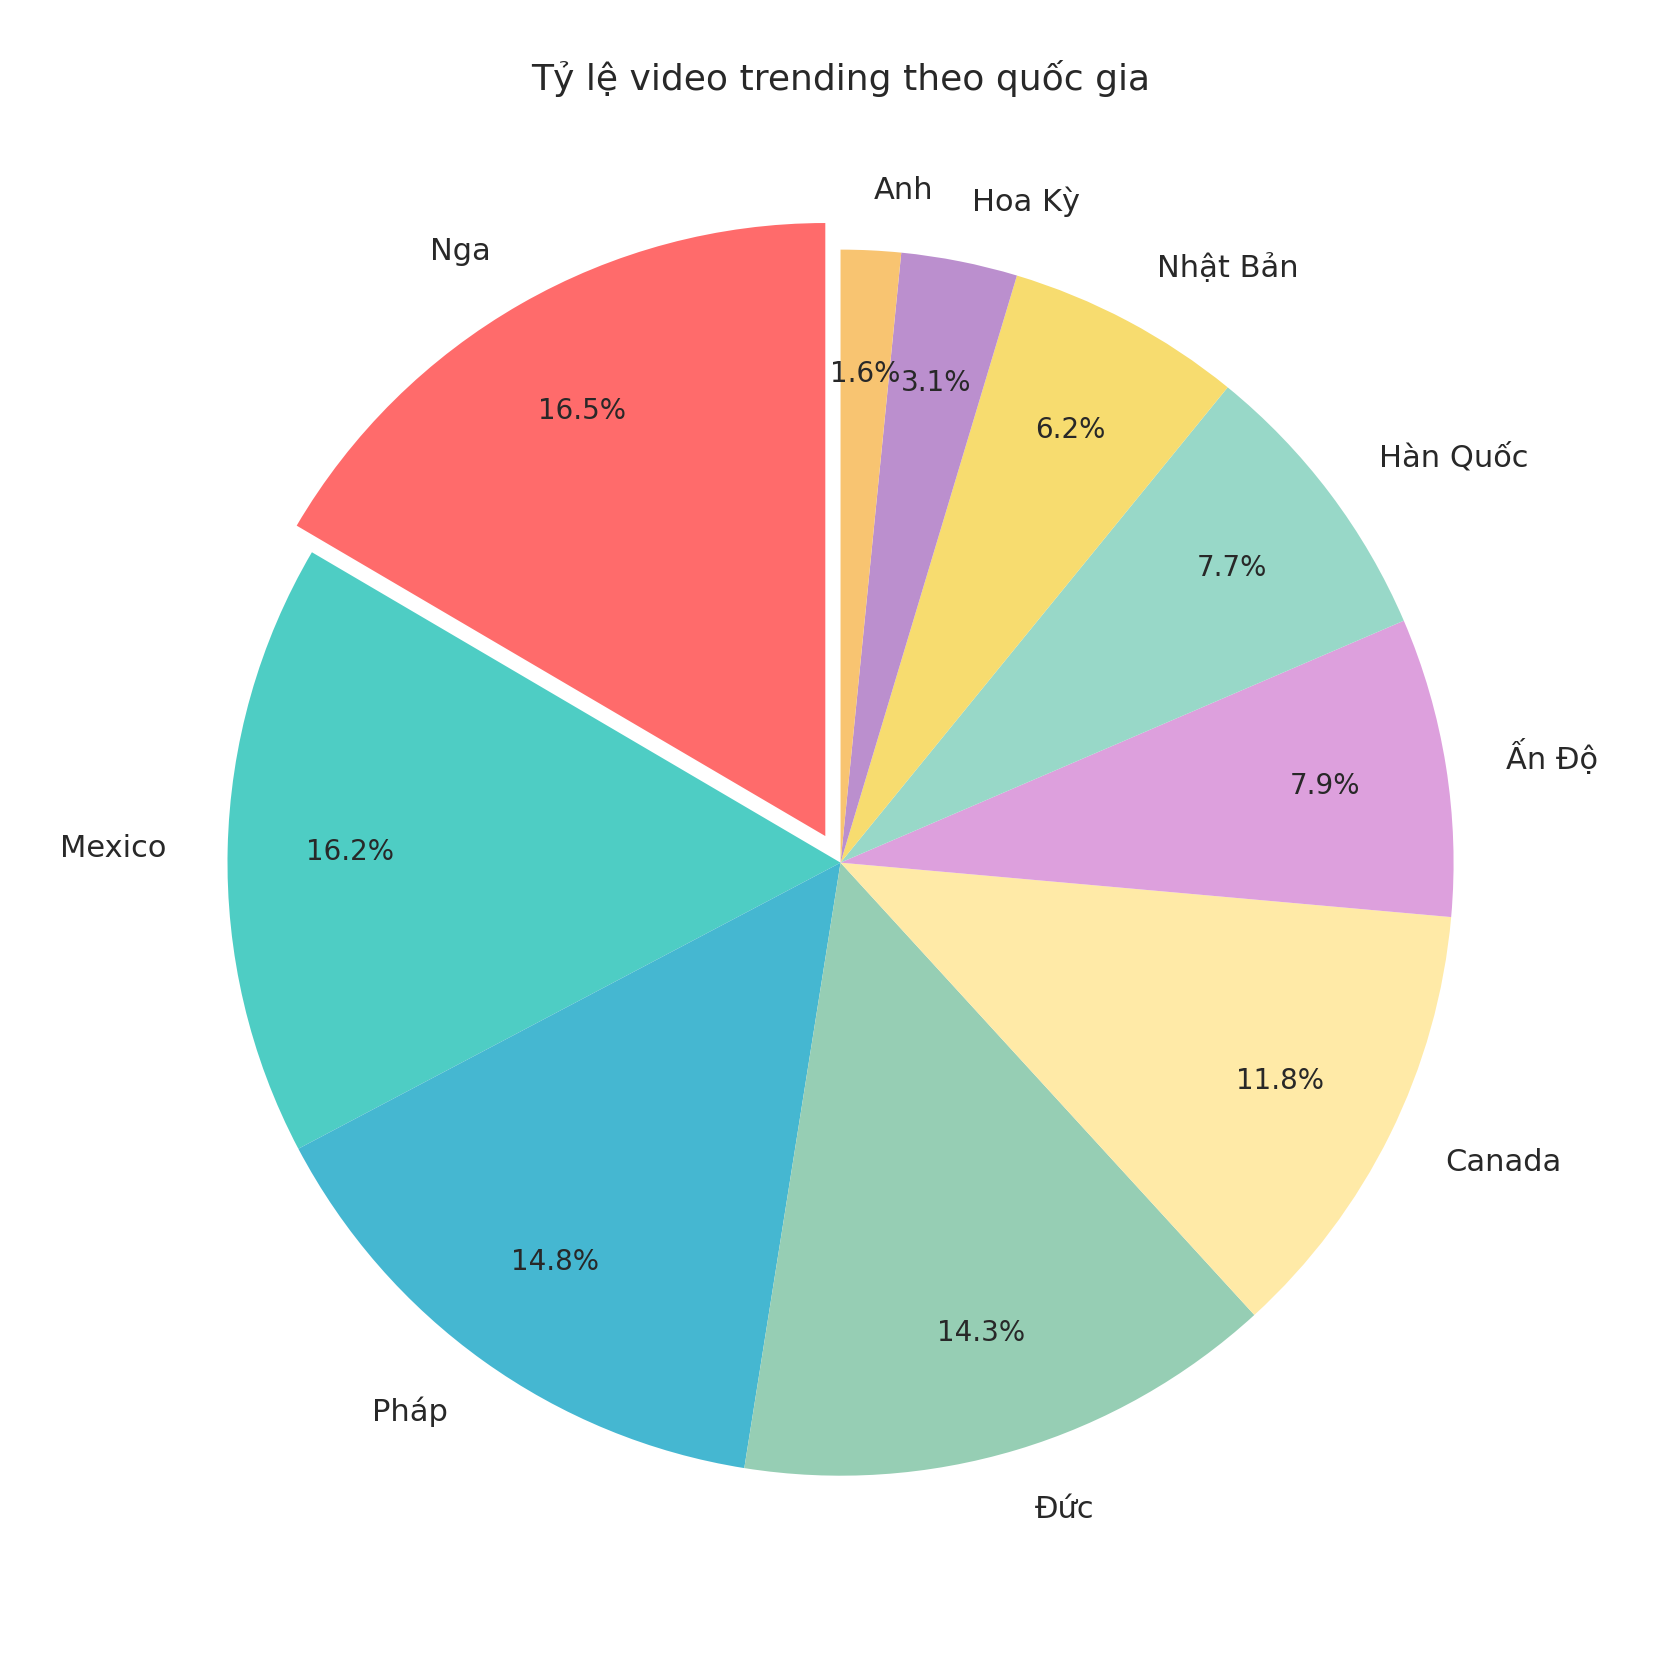

Tổng: 207,148 video

Nga: 34,282 video (16.5%)
Mexico: 33,513 video (16.2%)
Pháp: 30,581 video (14.8%)
Đức: 29,627 video (14.3%)
Canada: 24,427 video (11.8%)
Ấn Độ: 16,307 video (7.9%)
Hàn Quốc: 15,876 video (7.7%)
Nhật Bản: 12,912 video (6.2%)
Hoa Kỳ: 6,351 video (3.1%)
Anh: 3,272 video (1.6%)


In [325]:
import pandas as pd
import matplotlib.pyplot as plt

codes = ['US', 'CA', 'DE', 'FR', 'GB', 'IN', 'JP', 'KR', 'MX', 'RU']
names = {
    'US': 'Hoa Kỳ', 'CA': 'Canada', 'DE': 'Đức', 'FR': 'Pháp',
    'GB': 'Anh', 'IN': 'Ấn Độ', 'JP': 'Nhật Bản',
    'KR': 'Hàn Quốc', 'MX': 'Mexico', 'RU': 'Nga'
}

# Lấy số lượng video mỗi nước
counts = {}
for c in codes:
    if c in dataframes:
        counts[c] = len(dataframes[c])

# Tổng tất cả video
s = sum(counts.values())

# Dữ liệu để vẽ
data = []
for c in sorted(counts, key=counts.get, reverse=True):
    data.append({
        'code': c,
        'name': names[c],
        'count': counts[c],
        'pct': counts[c] / s * 100
    })

# Đưa vào DataFrame
df = pd.DataFrame(data)

# Màu tạm gán tay
cols = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7',
        '#DDA0DD', '#98D8C8', '#F7DC6F', '#BB8FCE', '#F8C471']

# Vẽ pie chart
plt.figure(figsize=(8, 8))
plt.pie(df['count'], 
        labels=df['name'],
        colors=cols[:len(df)],
        autopct='%1.1f%%',
        startangle=90,
        pctdistance=0.8,
        explode=[0.05] + [0]* (len(df) - 1))
plt.title('Tỷ lệ video trending theo quốc gia', fontsize=13)
plt.axis('equal')
plt.tight_layout()
plt.show()

# In kết quả
print(f"Tổng: {s:,} video\n")
for row in df.itertuples():
    print(f"{row.name}: {row.count:,} video ({row.pct:.1f}%)")


## Nhận xét từ biểu đồ phân bố video trending theo quốc gia

### 1. Tổng thể xu hướng
Biểu đồ cho thấy **Nga** và **Mexico** dẫn đầu về số lượng video trending với tỷ lệ lần lượt là **16.5%** và **16.2%**. Điều này phản ánh hoạt động sôi nổi của cộng đồng người dùng và tính đa dạng của nội dung trên nền tảng YouTube tại các thị trường này.

---

### 2. Sự phân hóa rõ rệt theo quốc gia

**Nhóm dẫn đầu:**
- **Nga (16.5%)** và **Mexico (16.2%)** chiếm ưu thế tuyệt đối, có thể do:
    - Tăng trưởng mạnh trong sản xuất nội dung số
    - Cộng đồng người dùng tích cực tương tác
    - Thuật toán khuyến khích nội dung địa phương

**Sự tương phản bất ngờ:**
- **Hoa Kỳ** chỉ đạt **3.1%** và **Anh** **1.6%** - thấp đáng kể so với kỳ vọng
- Nguyên nhân có thể là:
    - Thuật toán phân bổ trending khác biệt theo khu vực
    - Sự cạnh tranh khốc liệt trong thị trường nội dung trưởng thành
    - Người dùng phân tán qua nhiều nền tảng khác

---

### 3. Phân tích theo vùng địa lý

**Châu Âu thống trị:**
- **Nga (16.5%)**, **Pháp (14.8%)**, **Đức (14.3%)** đều trong top 4
- Tổng cộng chiếm **45.6%** tổng số video trending
- Cho thấy sự phát triển mạnh mẽ của nền kinh tế số châu Âu

**Bắc Mỹ có sự phân cực:**
- **Canada (11.8%)** vs **Hoa Kỳ (3.1%)**
- Phản ánh sự khác biệt trong chính sách nội dung hoặc hành vi người dùng

**Châu Á đa dạng:**
- **Ấn Độ (7.9%)**, **Hàn Quốc (7.7%)**, **Nhật Bản (6.2%)**
- Mỗi quốc gia có đặc thù riêng về văn hóa nội dung số



## **Trần Phan Minh Tiến**
### **Question 2**: Vẽ biểu đồ cột so sánh lượt thích, không thích, lượt xem và bình luận trung bình của các video thịnh hành.

CALCULATING AVERAGE METRICS FROM DATAFRAMES

US Dataset:
  Total videos: 6,351
  Views - Sum: 4,815,388,944 | Average: 758,209.56
  Likes - Sum: 219,068,662 | Average: 34,493.57
  Dislikes - Sum: 9,064,287 | Average: 1,427.22
  Comments - Sum: 28,590,343 | Average: 4,501.71

CA Dataset:
  Total videos: 24,427
  Views - Sum: 11,872,789,720 | Average: 486,051.90
  Likes - Sum: 449,417,025 | Average: 18,398.37
  Dislikes - Sum: 18,153,740 | Average: 743.18
  Comments - Sum: 63,402,056 | Average: 2,595.57

DE Dataset:
  Total videos: 29,627
  Views - Sum: 9,561,466,652 | Average: 322,728.14
  Likes - Sum: 359,455,193 | Average: 12,132.69
  Dislikes - Sum: 19,770,510 | Average: 667.31
  Comments - Sum: 48,969,750 | Average: 1,652.88

FR Dataset:
  Total videos: 30,581
  Views - Sum: 7,301,262,209 | Average: 238,751.58
  Likes - Sum: 285,881,915 | Average: 9,348.35
  Dislikes - Sum: 11,758,988 | Average: 384.52
  Comments - Sum: 32,939,527 | Average: 1,077.12

GB Dataset:
  Total videos: 3,2

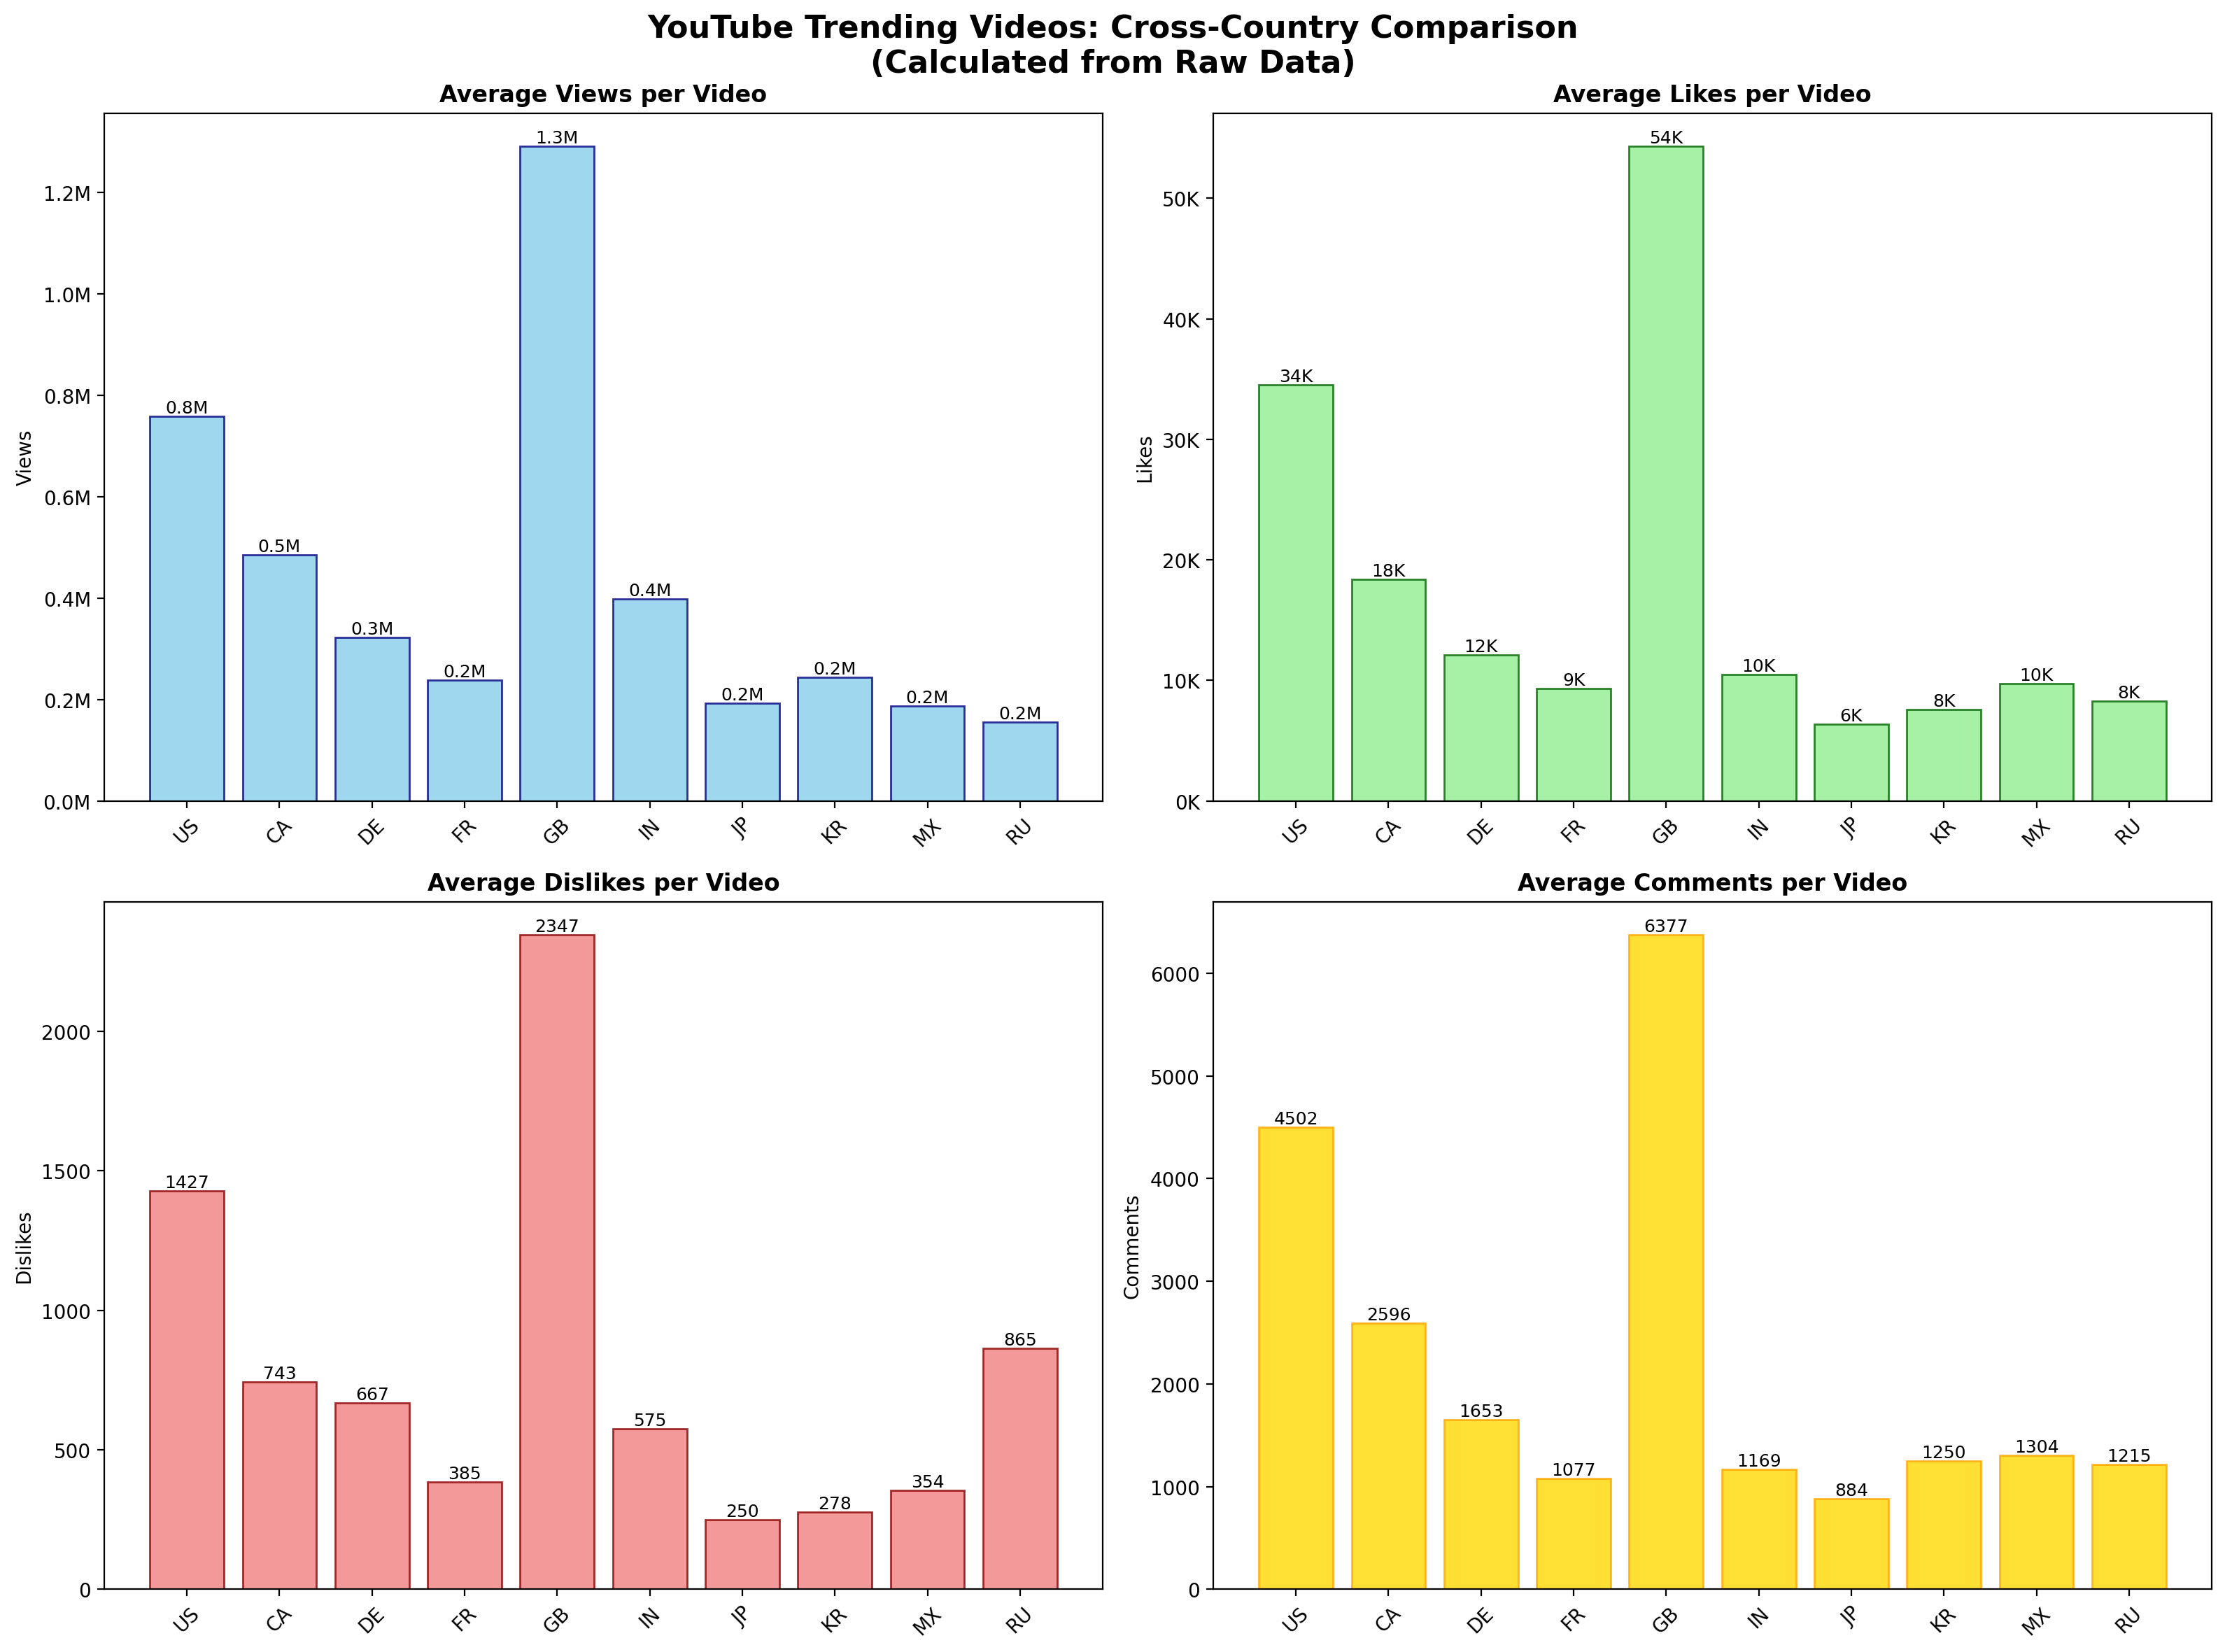


CALCULATING ENGAGEMENT RATES
Calculation Formula:
Like Rate % = (Average Likes / Average Views) × 100
Comment Rate % = (Average Comments / Average Views) × 100
Dislike Rate % = (Average Dislikes / Average Views) × 100

Country  Like Rate%   Comment Rate%   Dislike Rate%  
--------------------------------------------------
US       4.549        0.5937          0.1882         
CA       3.785        0.5340          0.1529         
DE       3.759        0.5122          0.2068         
FR       3.916        0.4511          0.1611         
GB       4.204        0.4936          0.1817         
IN       2.635        0.2938          0.1446         
JP       3.305        0.4582          0.1295         
KR       3.099        0.5128          0.1139         
MX       5.200        0.6956          0.1889         
RU       5.336        0.7824          0.5570         


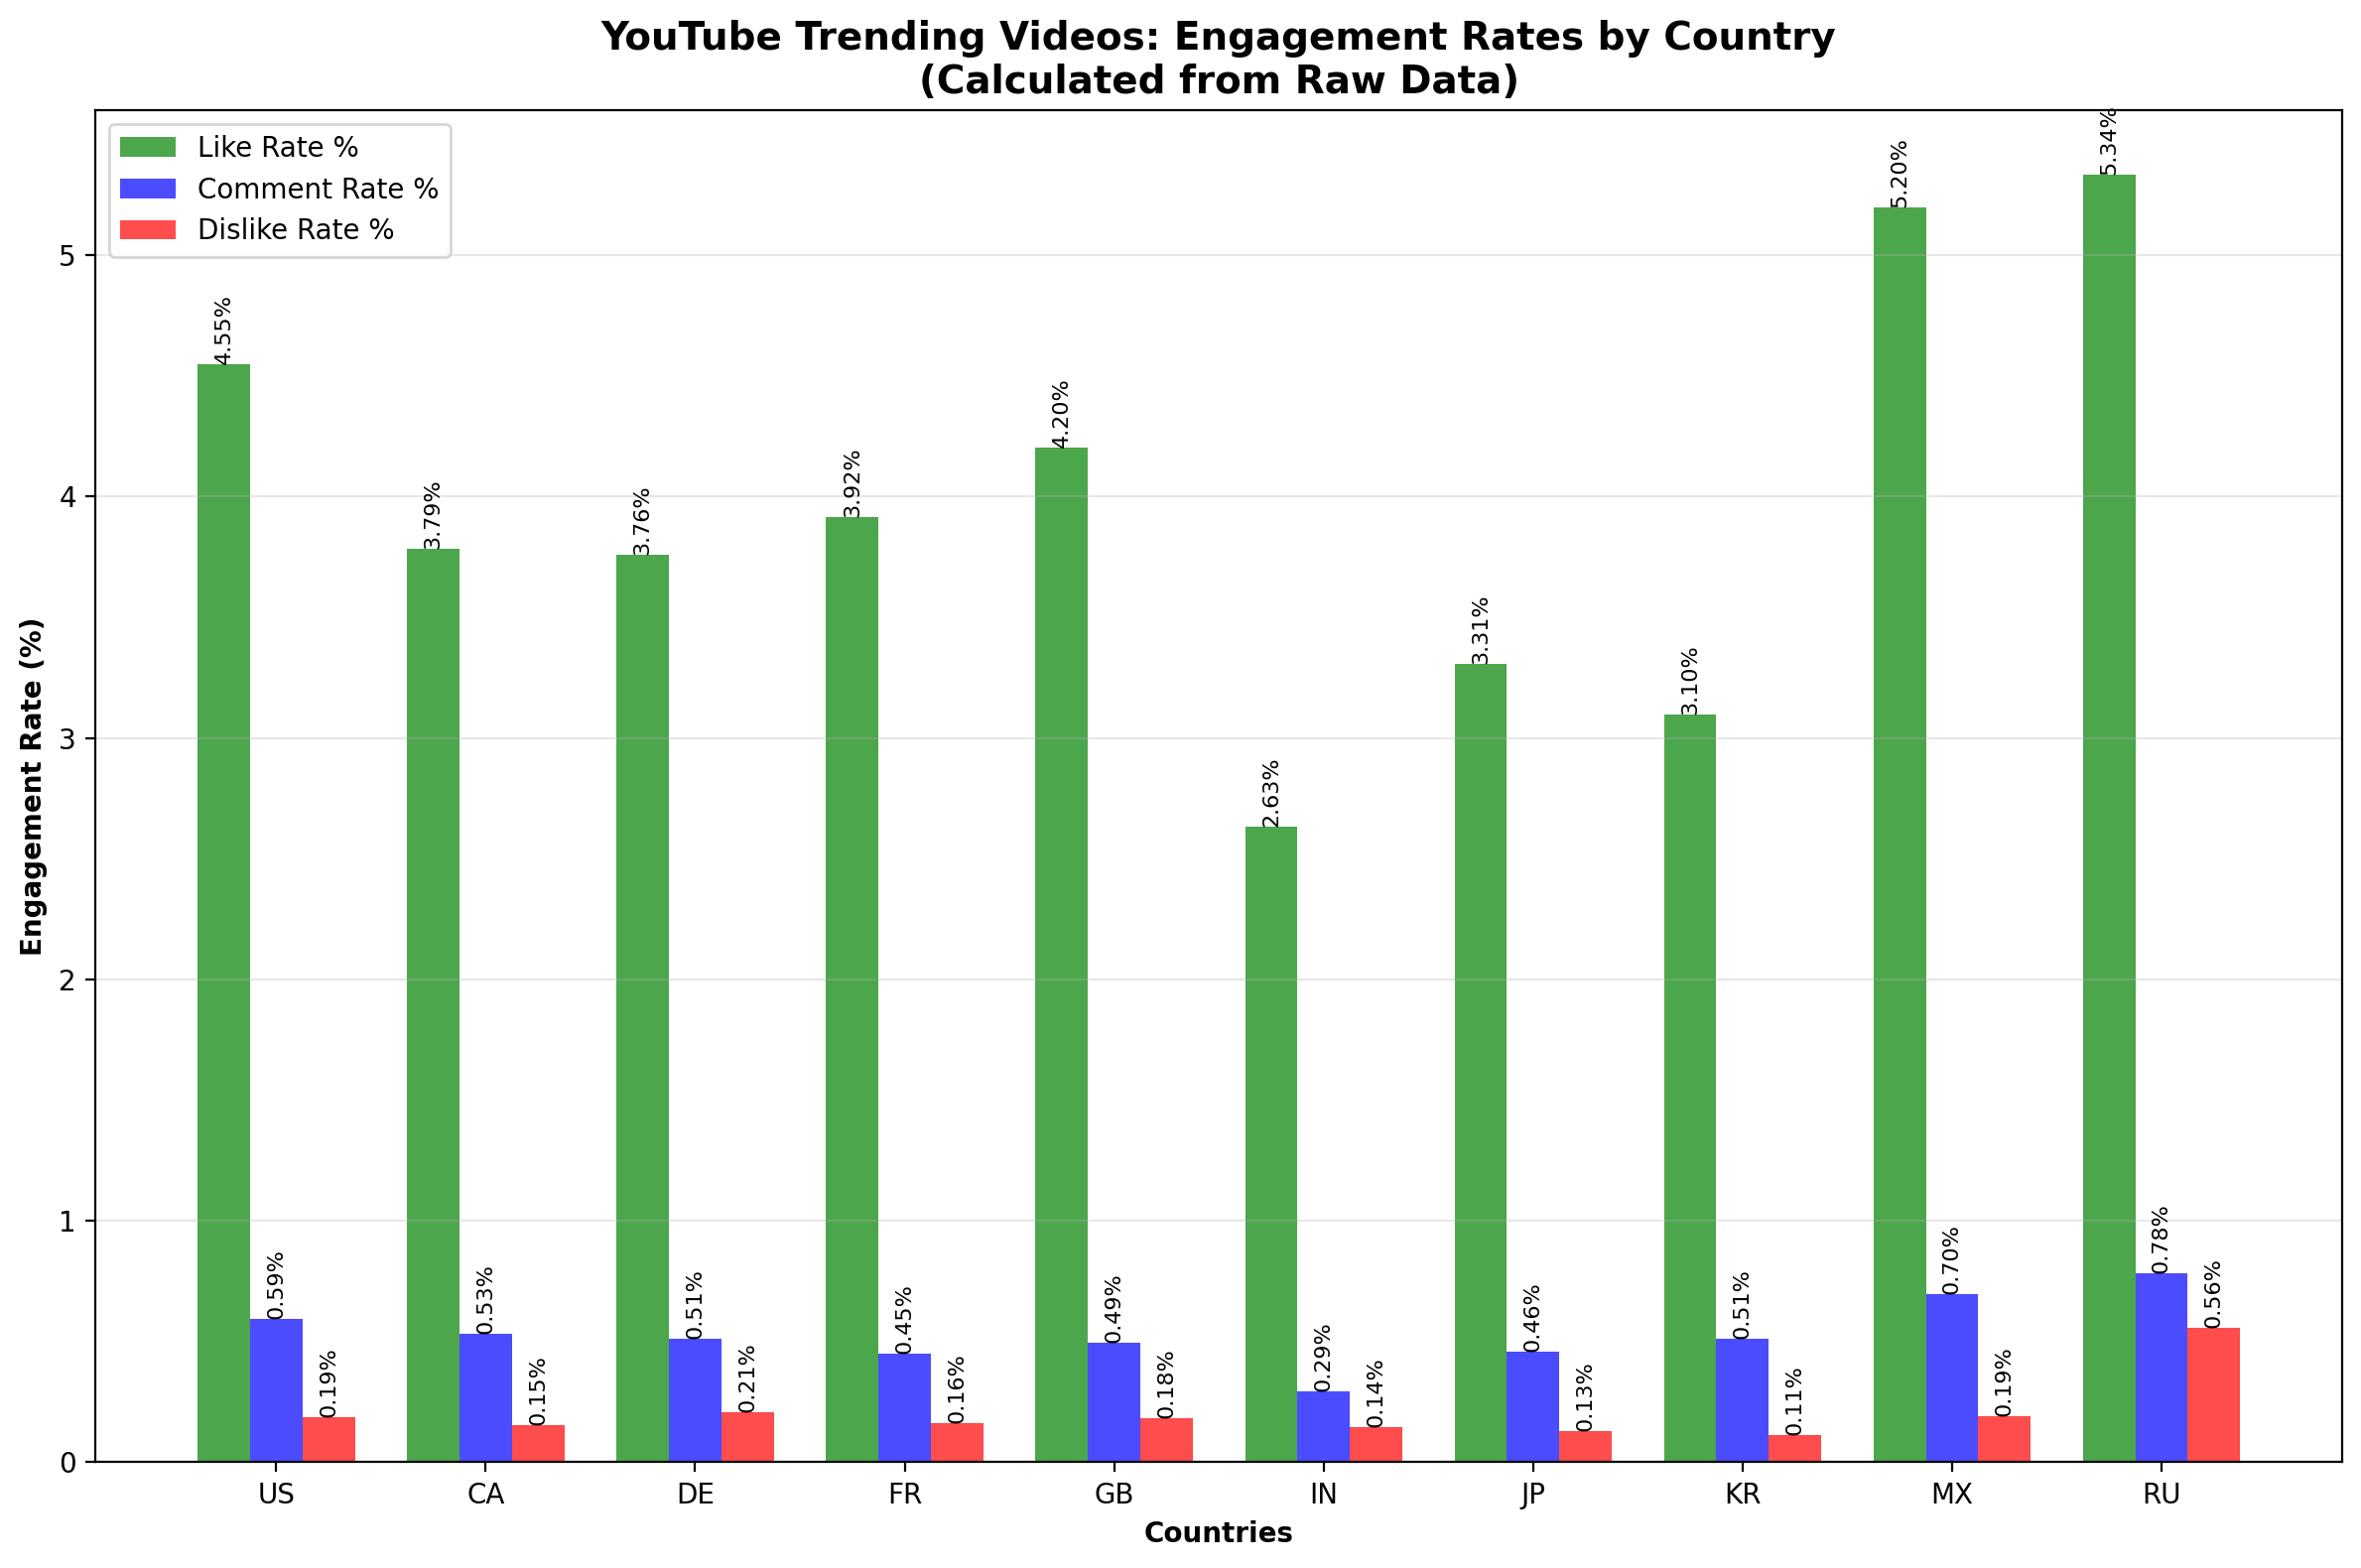


RANKING ANALYSIS (TOP 5)

🏆 Top 5 Countries by Views:
  1. GB: 1,292,004
  2. US: 758,210
  3. CA: 486,052
  4. IN: 397,775
  5. DE: 322,728

🏆 Top 5 Countries by Likes:
  1. GB: 54,319
  2. US: 34,494
  3. CA: 18,398
  4. DE: 12,133
  5. IN: 10,480

🏆 Top 5 Countries by Comments:
  1. GB: 6,377
  2. US: 4,502
  3. CA: 2,596
  4. DE: 1,653
  5. MX: 1,304

🏆 Top 5 Countries by Like Rate:
  1. RU:  5.336%
  2. MX:  5.200%
  3. US:  4.549%
  4. GB:  4.204%
  5. FR:  3.916%

FINAL CALCULATED SUMMARY
Country  Total_Videos  Avg_Views  Avg_Likes  Avg_Dislikes  Avg_Comments  Like_Rate  Comment_Rate
     US          6351  758209.56   34493.57       1427.22       4501.71       4.55          0.59
     CA         24427  486051.90   18398.37        743.18       2595.57       3.79          0.53
     DE         29627  322728.14   12132.69        667.31       1652.88       3.76          0.51
     FR         30581  238751.58    9348.35        384.52       1077.12       3.92          0.45
     GB      

In [326]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Set up the plot style
plt.style.use('default')
sns.set_palette("husl")

# Assume your dataframes are already loaded as shown in your code:
# dataframes = {'US': df_us, 'CA': df_ca, 'DE': df_de, ...}

# Step 1: Calculate average metrics for each country from the dataframes
print("="*60)
print("CALCULATING AVERAGE METRICS FROM DATAFRAMES")
print("="*60)

country_codes = ['US', 'CA', 'DE', 'FR', 'GB', 'IN', 'JP', 'KR', 'MX', 'RU']
comparison_data = {
    'Country': [],
    'Avg_Views': [],
    'Avg_Likes': [],
    'Avg_Dislikes': [],
    'Avg_Comments': [],
    'Total_Videos': []
}

# Calculate metrics for each country
for country in country_codes:
    # Get the dataframe for this country
    df = dataframes[country]
    
    # Calculate averages
    avg_views = df['views'].mean()
    avg_likes = df['likes'].mean()
    avg_dislikes = df['dislikes'].mean()
    avg_comments = df['comment_count'].mean()
    total_videos = len(df)
    
    # Store in comparison data
    comparison_data['Country'].append(country)
    comparison_data['Avg_Views'].append(avg_views)
    comparison_data['Avg_Likes'].append(avg_likes)
    comparison_data['Avg_Dislikes'].append(avg_dislikes)
    comparison_data['Avg_Comments'].append(avg_comments)
    comparison_data['Total_Videos'].append(total_videos)
    
    # Print calculation details
    print(f"\n{country} Dataset:")
    print(f"  Total videos: {total_videos:,}")
    print(f"  Views - Sum: {df['views'].sum():,} | Average: {avg_views:,.2f}")
    print(f"  Likes - Sum: {df['likes'].sum():,} | Average: {avg_likes:,.2f}")
    print(f"  Dislikes - Sum: {df['dislikes'].sum():,} | Average: {avg_dislikes:,.2f}")
    print(f"  Comments - Sum: {df['comment_count'].sum():,} | Average: {avg_comments:,.2f}")

# Create DataFrame from calculated data
df_comparison = pd.DataFrame(comparison_data)

print("\n" + "="*60)
print("CALCULATED COMPARISON TABLE")
print("="*60)
print(df_comparison.round(2))

# Step 2: Create visualization with calculated data
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('YouTube Trending Videos: Cross-Country Comparison\n(Calculated from Raw Data)', 
             fontsize=16, fontweight='bold')

# 1. Average Views
bars1 = axes[0,0].bar(df_comparison['Country'], df_comparison['Avg_Views'], 
                      color='skyblue', alpha=0.8, edgecolor='navy')
axes[0,0].set_title('Average Views per Video', fontweight='bold')
axes[0,0].set_ylabel('Views')
axes[0,0].tick_params(axis='x', rotation=45)
axes[0,0].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}M'))

# Add value labels on bars
for bar in bars1:
    height = bar.get_height()
    axes[0,0].text(bar.get_x() + bar.get_width()/2., height,
                   f'{height/1e6:.1f}M', ha='center', va='bottom', fontsize=9)

# 2. Average Likes
bars2 = axes[0,1].bar(df_comparison['Country'], df_comparison['Avg_Likes'], 
                      color='lightgreen', alpha=0.8, edgecolor='darkgreen')
axes[0,1].set_title('Average Likes per Video', fontweight='bold')
axes[0,1].set_ylabel('Likes')
axes[0,1].tick_params(axis='x', rotation=45)
axes[0,1].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e3:.0f}K'))

# Add value labels
for bar in bars2:
    height = bar.get_height()
    axes[0,1].text(bar.get_x() + bar.get_width()/2., height,
                   f'{height/1e3:.0f}K', ha='center', va='bottom', fontsize=9)

# 3. Average Dislikes
bars3 = axes[1,0].bar(df_comparison['Country'], df_comparison['Avg_Dislikes'], 
                      color='lightcoral', alpha=0.8, edgecolor='darkred')
axes[1,0].set_title('Average Dislikes per Video', fontweight='bold')
axes[1,0].set_ylabel('Dislikes')
axes[1,0].tick_params(axis='x', rotation=45)

# Add value labels
for bar in bars3:
    height = bar.get_height()
    axes[1,0].text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.0f}', ha='center', va='bottom', fontsize=9)

# 4. Average Comments
bars4 = axes[1,1].bar(df_comparison['Country'], df_comparison['Avg_Comments'], 
                      color='gold', alpha=0.8, edgecolor='orange')
axes[1,1].set_title('Average Comments per Video', fontweight='bold')
axes[1,1].set_ylabel('Comments')
axes[1,1].tick_params(axis='x', rotation=45)

# Add value labels
for bar in bars4:
    height = bar.get_height()
    axes[1,1].text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.0f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# Step 3: Calculate and show engagement rates
print("\n" + "="*60)
print("CALCULATING ENGAGEMENT RATES")
print("="*60)

df_comparison['Like_Rate'] = (df_comparison['Avg_Likes'] / df_comparison['Avg_Views'] * 100)
df_comparison['Comment_Rate'] = (df_comparison['Avg_Comments'] / df_comparison['Avg_Views'] * 100)
df_comparison['Dislike_Rate'] = (df_comparison['Avg_Dislikes'] / df_comparison['Avg_Views'] * 100)

print("Calculation Formula:")
print("Like Rate % = (Average Likes / Average Views) × 100")
print("Comment Rate % = (Average Comments / Average Views) × 100")
print("Dislike Rate % = (Average Dislikes / Average Views) × 100")
print()

print(f"{'Country':<8} {'Like Rate%':<12} {'Comment Rate%':<15} {'Dislike Rate%':<15}")
print("-"*50)
for _, row in df_comparison.iterrows():
    print(f"{row['Country']:<8} {row['Like_Rate']:<12.3f} {row['Comment_Rate']:<15.4f} {row['Dislike_Rate']:<15.4f}")

# Step 4: Create engagement rate visualization
fig, ax = plt.subplots(figsize=(12, 8))

x = np.arange(len(df_comparison['Country']))
width = 0.25

bars1 = ax.bar(x - width, df_comparison['Like_Rate'], width, 
               label='Like Rate %', color='green', alpha=0.7)
bars2 = ax.bar(x, df_comparison['Comment_Rate'], width, 
               label='Comment Rate %', color='blue', alpha=0.7)
bars3 = ax.bar(x + width, df_comparison['Dislike_Rate'], width, 
               label='Dislike Rate %', color='red', alpha=0.7)

# Add value labels on engagement bars
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}%', ha='center', va='bottom', fontsize=8, rotation=90)

ax.set_xlabel('Countries', fontweight='bold')
ax.set_ylabel('Engagement Rate (%)', fontweight='bold')
ax.set_title('YouTube Trending Videos: Engagement Rates by Country\n(Calculated from Raw Data)', 
             fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(df_comparison['Country'])
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Step 5: Show ranking analysis
print("\n" + "="*60)
print("RANKING ANALYSIS (TOP 5)")
print("="*60)

rankings = {
    'Views': df_comparison.nlargest(5, 'Avg_Views')[['Country', 'Avg_Views']],
    'Likes': df_comparison.nlargest(5, 'Avg_Likes')[['Country', 'Avg_Likes']],
    'Comments': df_comparison.nlargest(5, 'Avg_Comments')[['Country', 'Avg_Comments']],
    'Like Rate': df_comparison.nlargest(5, 'Like_Rate')[['Country', 'Like_Rate']]
}

for metric, data in rankings.items():
    print(f"\n🏆 Top 5 Countries by {metric}:")
    for i, (_, row) in enumerate(data.iterrows(), 1):
        if metric == 'Like Rate':
            print(f"  {i}. {row['Country']}: {row[f'{metric.replace(" ", "_")}']: .3f}%")
        else:
            print(f"  {i}. {row['Country']}: {row[f'Avg_{metric}']:,.0f}")

# Step 6: Create a summary statistics DataFrame
print("\n" + "="*60)
print("FINAL CALCULATED SUMMARY")
print("="*60)

summary_df = df_comparison[['Country', 'Total_Videos', 'Avg_Views', 'Avg_Likes', 
                           'Avg_Dislikes', 'Avg_Comments', 'Like_Rate', 'Comment_Rate']].round(2)
print(summary_df.to_string(index=False))

# Optional: Save results to CSV
# summary_df.to_csv('youtube_comparison_calculated.csv', index=False)
# print("\n✅ Results saved to 'youtube_comparison_calculated.csv'")

print("\n" + "="*60)
print("CALCULATION COMPLETE!")
print("="*60)

## **Trần Minh Thuận**

### **Question 3**: Top 7 kênh YouTube có số lượng video thịnh hành nhiều nhất trên toàn cầu

Phân tích để nhận diện những nhà sáng tạo/kênh có khả năng tạo ra nội dung trending một cách nhất quán và hiệu quả nhất.


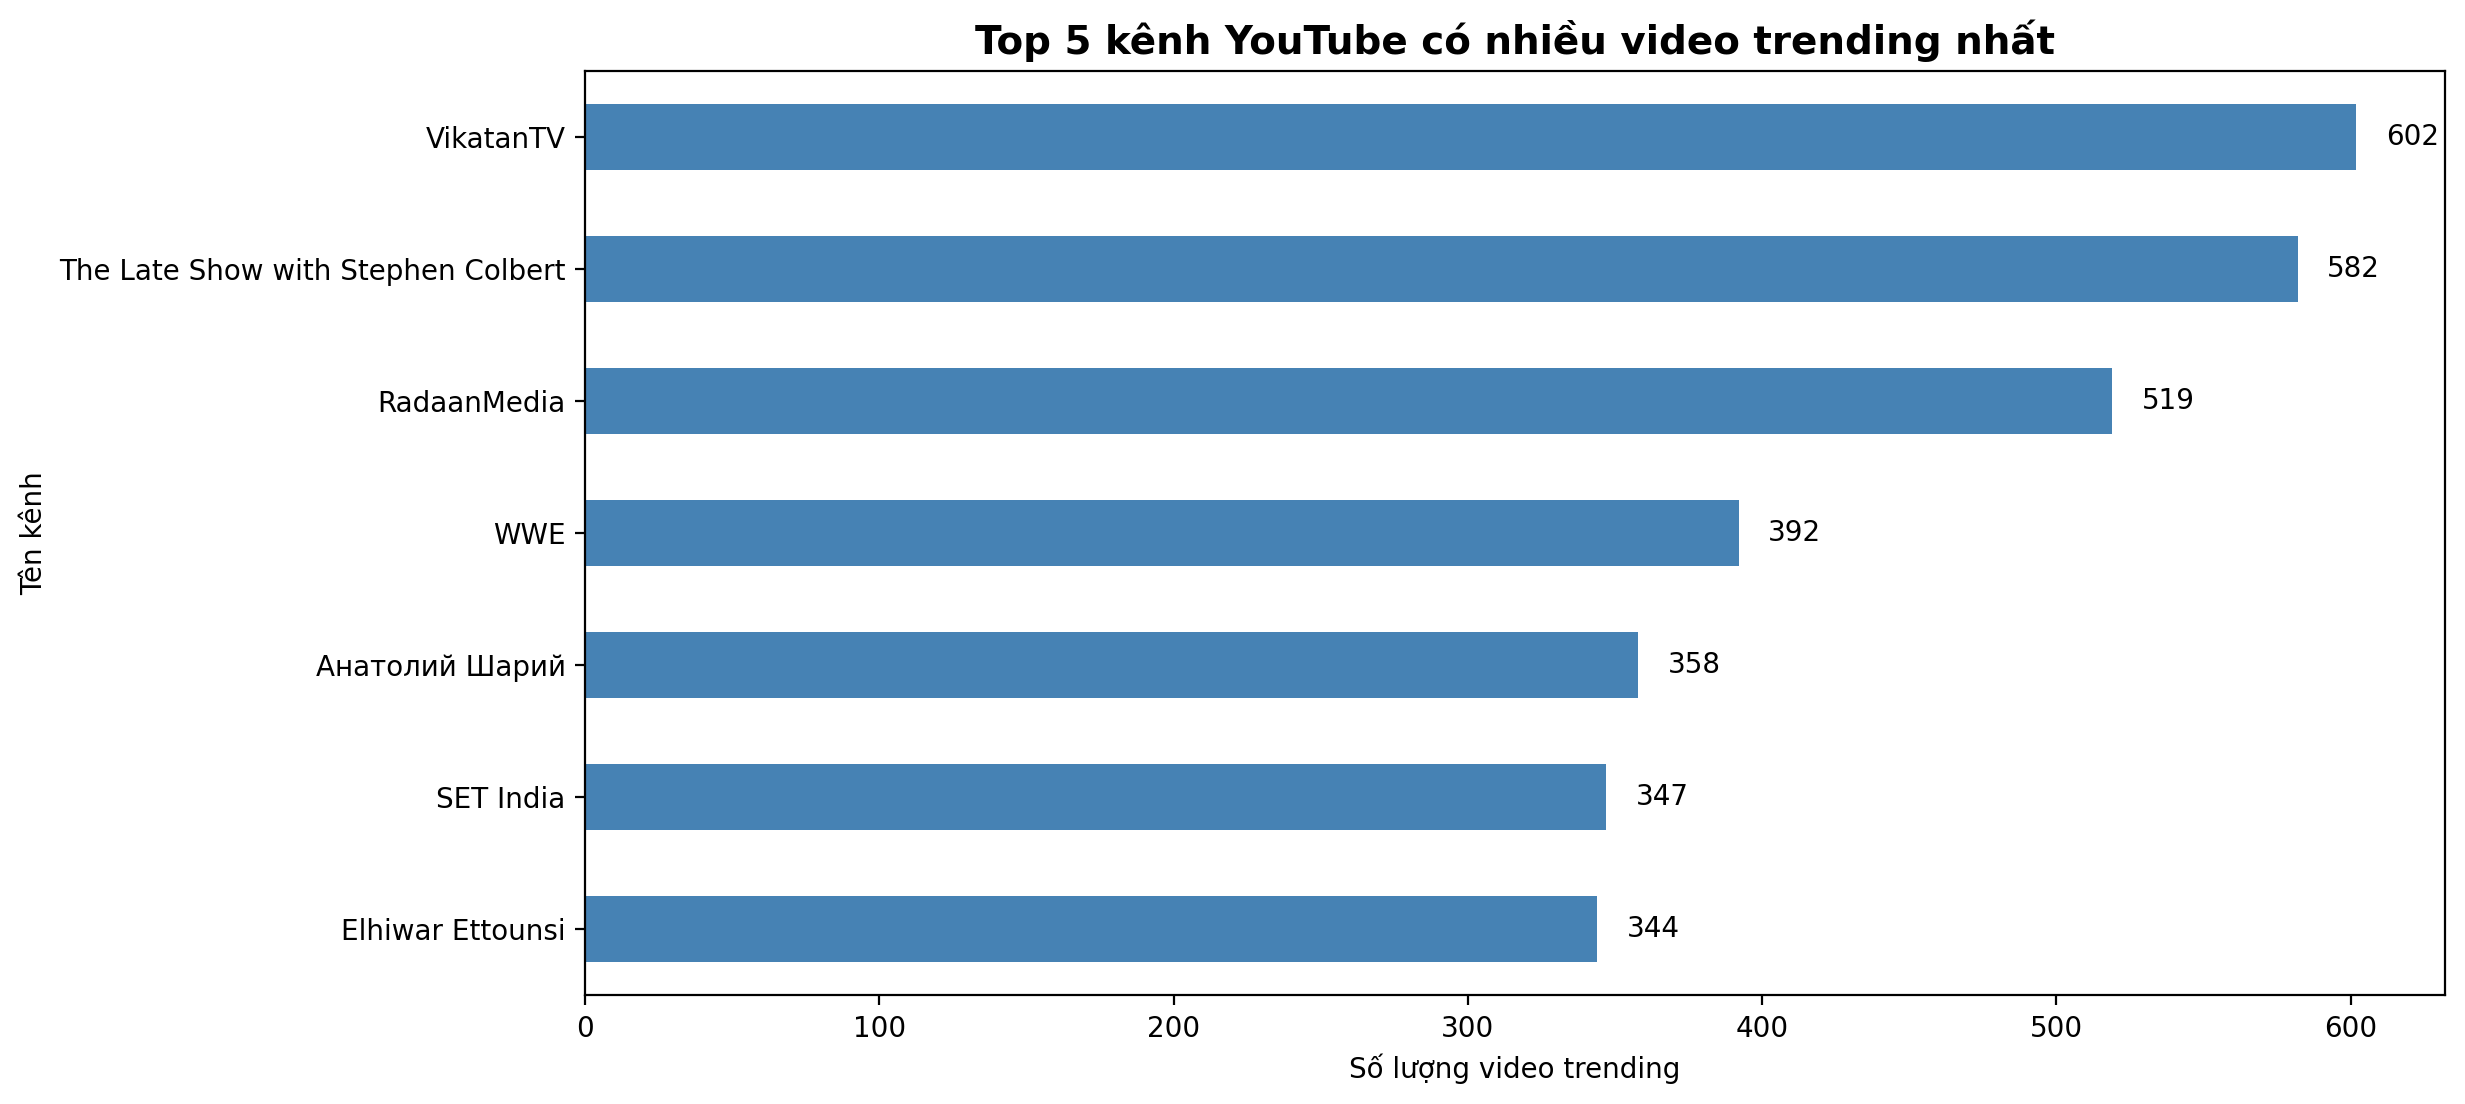

In [332]:
# Top 5 kênh có nhiều video trending nhất
top_channels = combined_df['channel_title'].value_counts().head(7)

plt.figure(figsize=(12, 6))
# [::-1] để đảo ngược thứ tự cột trong biểu đồ ngang
top_channels[::-1].plot(kind='barh', color='steelblue')

for i, v in enumerate(top_channels[::-1]):
    plt.text(v + 10, i, f'{v:,}', color='black', va='center', fontsize=10)

plt.title('Top 5 kênh YouTube có nhiều video trending nhất', fontsize=14, fontweight='bold')
plt.xlabel('Số lượng video trending')
plt.ylabel('Tên kênh')
plt.show()

## **Trần Minh Thuận**

### **Question 4**: Vẽ biểu đồ heatmap thể hiện mức độ trùng lặp video thịnh hành giữa các quốc gia

Phân tích phân phối các thể loại video giữa các quốc gia để thấy rõ sự khác biệt trong xu hướng nội dung và sự tương đồng giữa các khu vực. Phân tích này sử dụng thông tin từ tiêu đề video để phân loại nội dung.


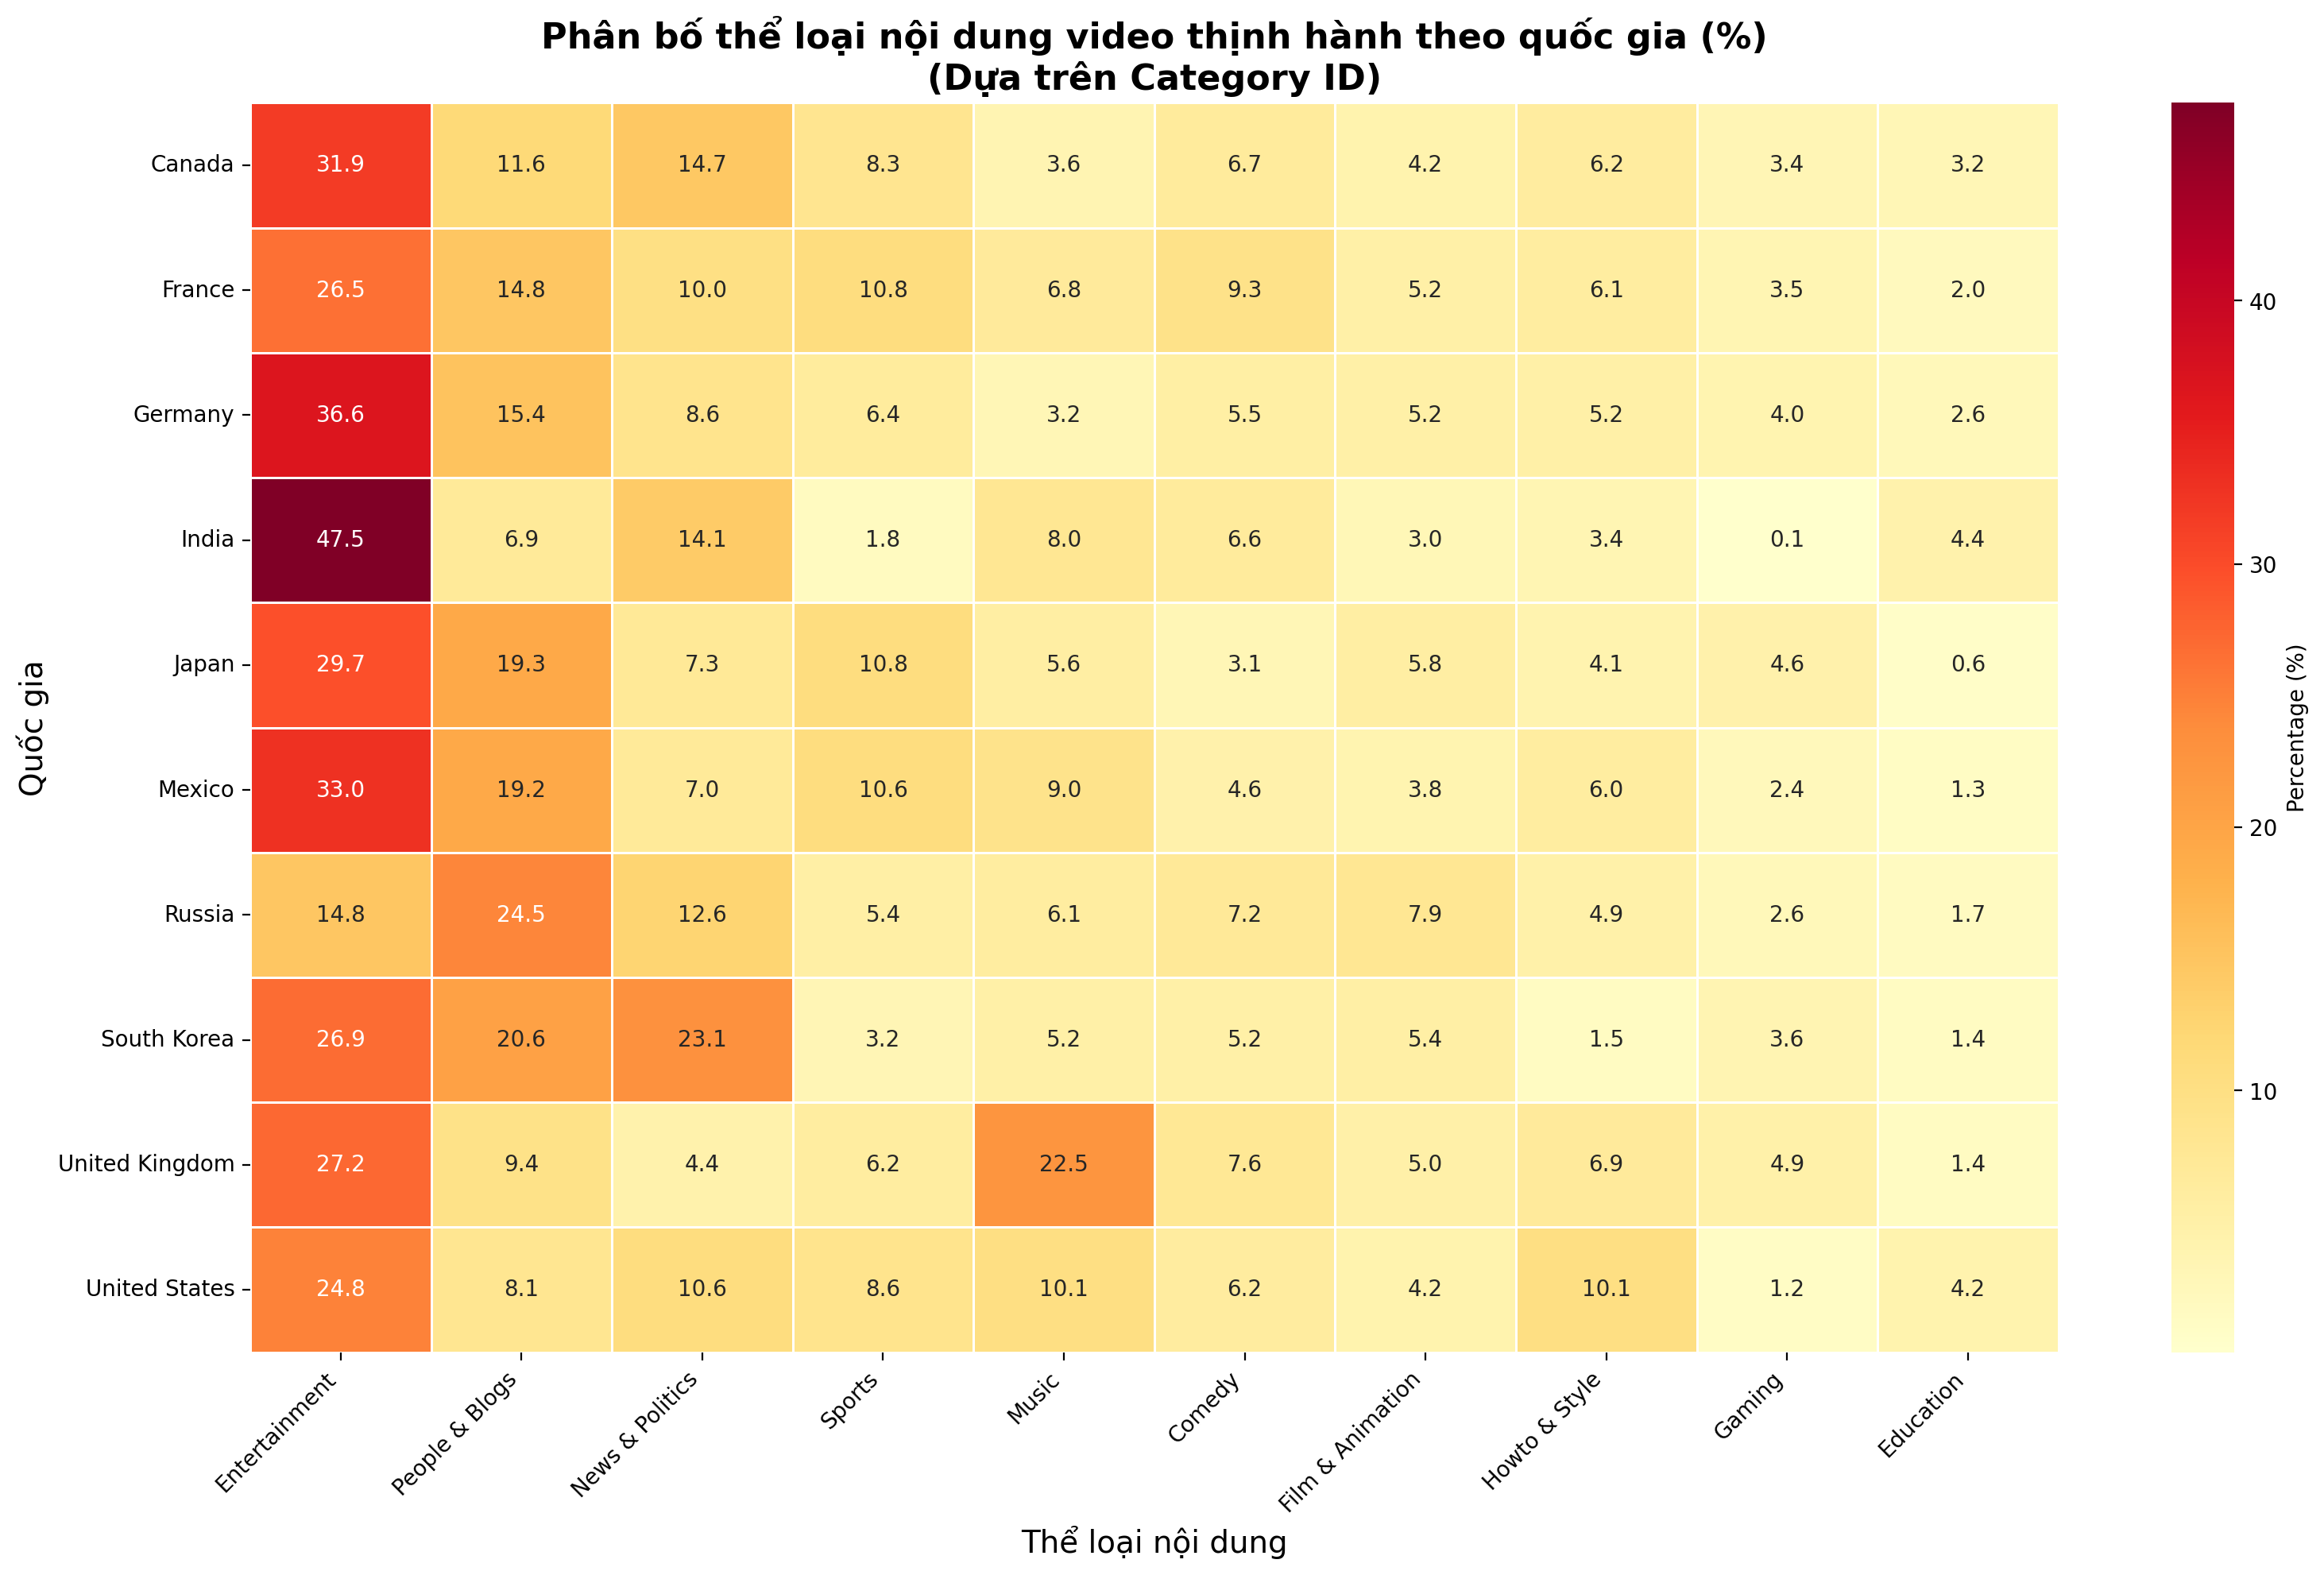

In [335]:
# Create a mapping of category_id to category names
# http://stackoverflow.com/questions/17698040/ddg#35877512
category_mapping = {
    1: 'Film & Animation',
    2: 'Autos & Vehicles', 
    10: 'Music',
    15: 'Pets & Animals',
    17: 'Sports',
    18: 'Short Movies',
    19: 'Travel & Events',
    20: 'Gaming',
    21: 'Videoblogging',
    22: 'People & Blogs',
    23: 'Comedy',
    24: 'Entertainment',
    25: 'News & Politics',
    26: 'Howto & Style',
    27: 'Education',
    28: 'Science & Technology',
    29: 'Nonprofits & Activism',
    30: 'Movies',
    31: 'Anime/Animation',
    32: 'Action/Adventure',
    33: 'Classics',
    34: 'Comedy',
    35: 'Documentary',
    36: 'Drama',
    37: 'Family',
    38: 'Foreign',
    39: 'Horror',
    40: 'Sci-Fi/Fantasy',
    41: 'Thriller',
    42: 'Shorts',
    43: 'Shows',
    44: 'Trailers'
}

# Add country name to combined_df for analysis
combined_df['country_code'] = ''
for country_code, df_country in dataframes.items():
    mask = combined_df['video_id'].isin(df_country['video_id'])
    combined_df.loc[mask, 'country_code'] = country_code

# Map country codes to country names
combined_df['country_name'] = combined_df['country_code'].map(country_names)

# Map category_id to category names
combined_df['category_name'] = combined_df['category_id'].map(category_mapping)

# Handle any unmapped categories
combined_df['category_name'] = combined_df['category_name'].fillna('Other')

# Create cross-tabulation of country vs category
content_by_country = pd.crosstab(combined_df['country_name'], combined_df['category_name'])

# Calculate percentage distribution for fair comparison between countries
content_pct = content_by_country.div(content_by_country.sum(axis=1), axis=0) * 100

# Select top categories to avoid overcrowding the heatmap
top_categories = content_by_country.sum().nlargest(10).index
content_pct_filtered = content_pct[top_categories]

# Create heatmap showing percentage distribution of content by country
plt.figure(figsize=(16, 10))
sns.heatmap(content_pct_filtered, annot=True, fmt='.1f', cmap='YlOrRd', 
            linewidths=0.5, cbar_kws={'label': 'Percentage (%)'})
plt.title('Phân bố thể loại nội dung video thịnh hành theo quốc gia (%)\n(Dựa trên Category ID)', 
          fontsize=16, fontweight='bold')
plt.ylabel('Quốc gia', fontsize=14)
plt.xlabel('Thể loại nội dung', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Nhận xét từ biểu đồ heatmap phân bố nội dung:

Dựa trên phân tích 207,148 video từ 10 quốc gia với 18 thể loại khác nhau, ta có những phát hiện thú vị:

#### **1. Xu hướng toàn cầu**
- **Entertainment** là thể loại thống trị (29.2% tổng số video), phổ biến ở hầu hết các quốc gia
- **People & Blogs** đứng thứ 2 (17.1%), cho thấy xu hướng cá nhân hóa nội dung mạnh mẽ
- **News & Politics** chiếm 11.3%, phản ánh nhu cầu thông tin cao của người xem

#### **2. Đặc trưng riêng biệt theo vùng**

**Nhóm châu Á:**
- **Ấn Độ**: Nổi bật với Entertainment cao nhất (47.5%), cho thấy nhu cầu giải trí lớn
- **Hàn Quốc**: Cân bằng giữa Entertainment (26.9%) và News & Politics (23.1%), phản ánh quan tâm chính trị cao
- **Nhật Bản**: Tập trung Entertainment (29.7%) và People & Blogs (19.3%)

**Nhóm châu Âu:**
- **Đức**: Dẫn đầu về Entertainment (36.6%) và People & Blogs (15.4%)
- **Pháp**: Cân bằng giữa Entertainment (26.5%), People & Blogs (14.8%) và Sports (10.8%)
- **Anh**: Đặc biệt với Music cao (22.5%), chỉ sau Entertainment (27.2%)

**Nhóm Bắc Mỹ:**
- **Canada**: Phân bố đều với Entertainment (31.9%) và quan tâm tin tức cao (14.7%)
- **Mỹ**: Cân bằng Entertainment (24.8%), News & Politics (10.6%) và Music (10.1%)

**Nhóm đặc biệt:**
- **Nga**: Duy nhất có People & Blogs dẫn đầu (24.5%), cho thấy văn hóa chia sẻ cá nhân mạnh
- **Mexico**: Entertainment cao (33.0%) với People & Blogs phát triển (19.2%)

#### **3. Insights chiến lược cho content creator**

**Thị trường toàn cầu**: Tập trung vào Entertainment và People & Blogs để có охват rộng nhất

**Thị trường từng khu vực**:
- **Châu Á**: Đầu tư vào Entertainment chất lượng cao
- **Châu Âu**: Kết hợp Entertainment với Sports và Music  
- **Bắc Mỹ**: Cân bằng giữa giải trí và thông tin
- **Nga**: Tận dụng xu hướng vlog/personal content mạnh mẽ

Sự đa dạng này phản ánh khác biệt văn hóa sâu sắc và mở ra cơ hội tối ưu nội dung theo từng thị trường cụ thể.

##### **Hoàng Văn Đức**

    Question 5: Vẽ biểu đồ cột thể hiện số lượng video thịnh hành theo quý qua các năm (cau nay khong on)

##### **Hoàng Văn Đức**

    Question 6: Vẽ biểu đồ đường hoặc cột thể hiện lượt xem trung bình theo từng ngày trong tuần

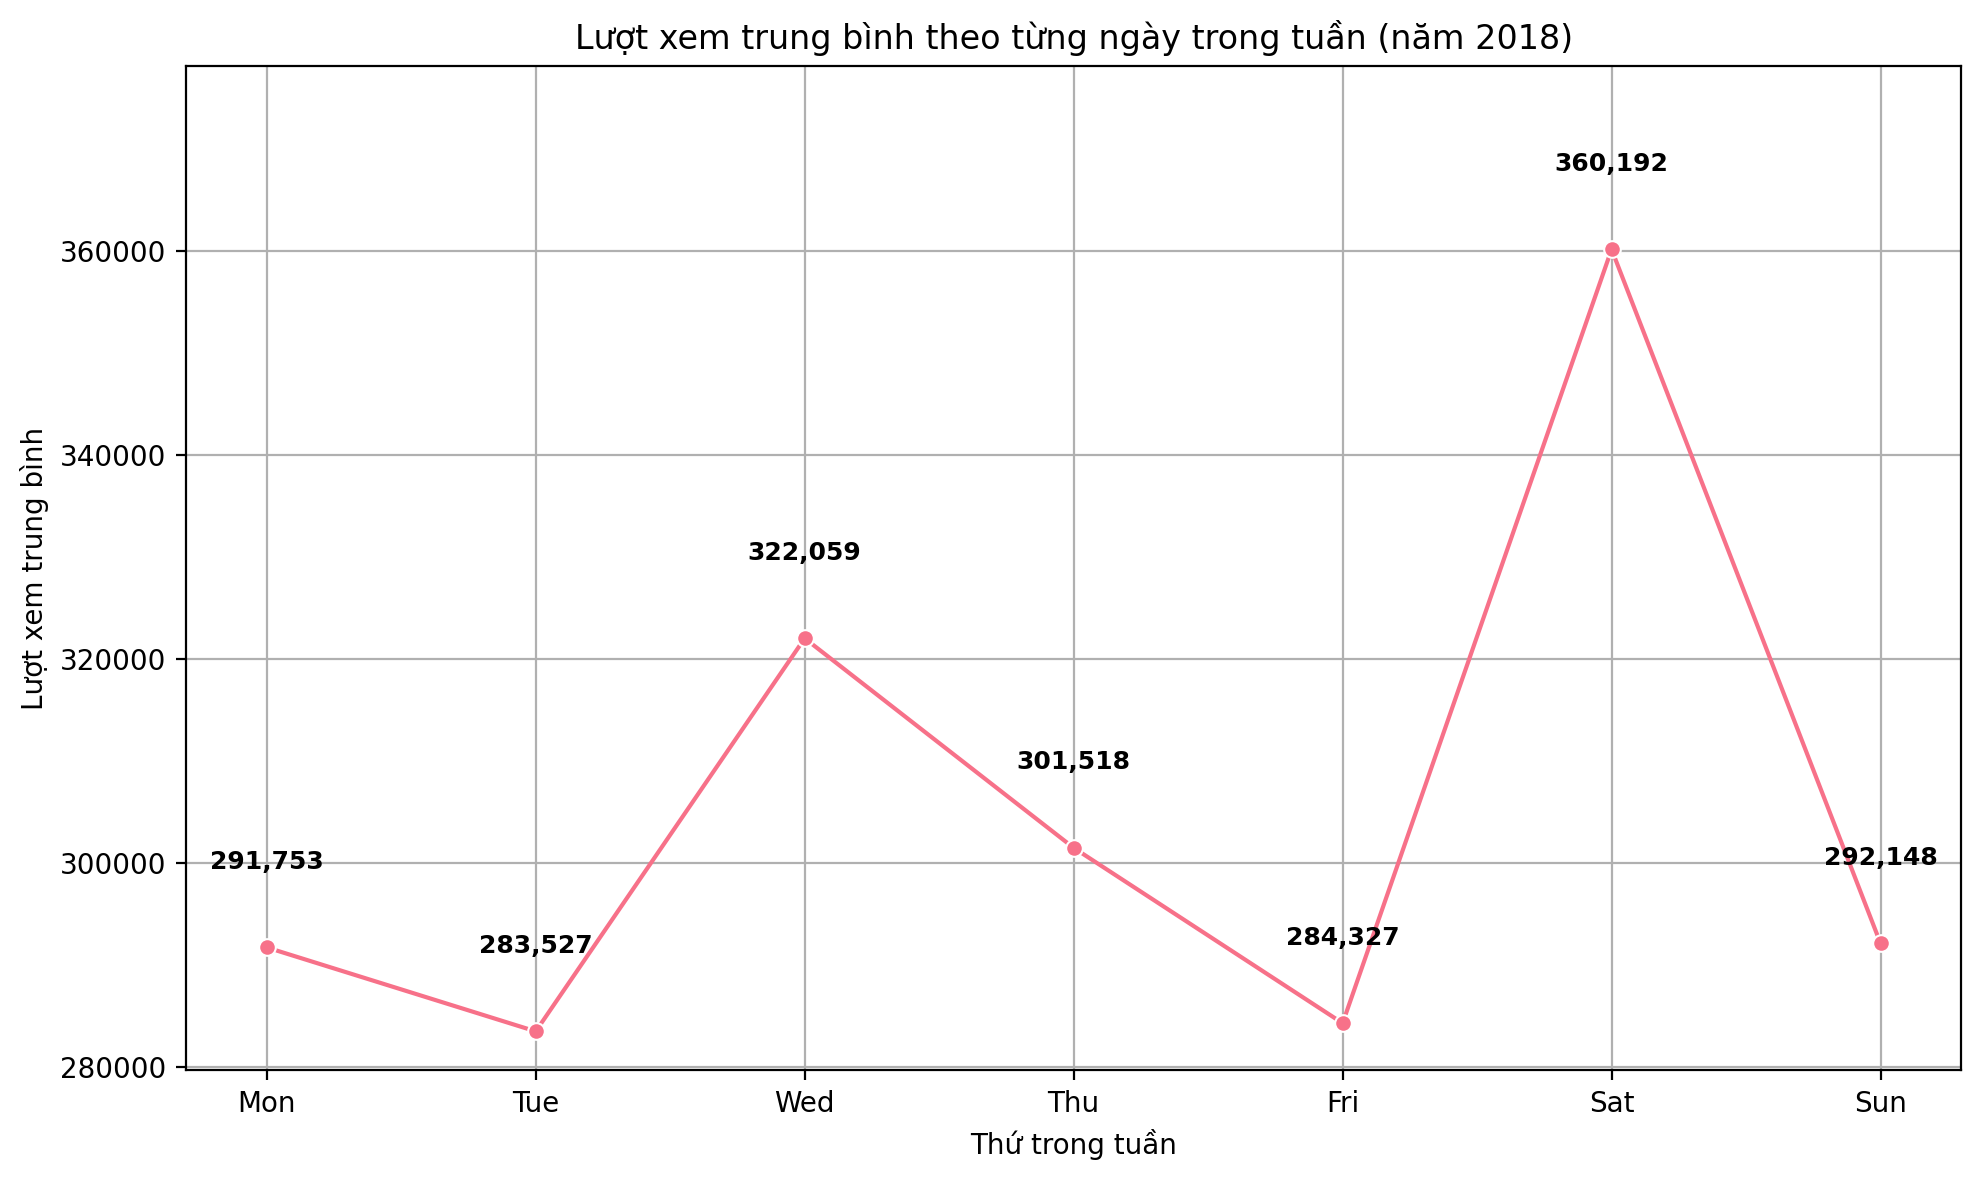

In [329]:
# Tính lượt xem trung bình theo ngày trong tuần
views_by_weekday = df_2018.groupby("weekday_name")["views"].mean().reindex(weekday_names).reset_index()

# Vẽ biểu đồ đường
plt.figure(figsize=(10,6))
line_plot = sns.lineplot(data=views_by_weekday, x="weekday_name", y="views", marker="o")

# Tìm giá trị max để điều chỉnh y-axis limits
max_views = views_by_weekday['views'].max()
plt.ylim(top= max_views * 1.05)  # Thêm 5% padding ở trên de so khong bi o ben ngooai bieu do

# Thêm số liệu vào mỗi điểm với vị trí được điều chỉnh
for i, point in views_by_weekday.iterrows():
    plt.text(i, point['views'] + max_views * 0.02, f'{point["views"]:,.0f}', 
             ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.title("Lượt xem trung bình theo từng ngày trong tuần (năm 2018)")
plt.xlabel("Thứ trong tuần")
plt.ylabel("Lượt xem trung bình")
plt.grid(True)
plt.tight_layout()
plt.show()


Nhan xet ve li do Wednesday va Saturday co so luot xem cao nhat trong tuan, cho thay nguoi dung co xu huong xem video vao giua tuan va cuoi tuan......
